# 0.0. IMPORTS

## 0.1. Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import datetime
import random
import pickle

from IPython.display            import Image

from boruta                     import BorutaPy
from scipy                      import stats

from sklearn.preprocessing      import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics            import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.ensemble           import RandomForestRegressor
from sklearn.linear_model       import LinearRegression, Lasso
from sklearn.model_selection    import cross_val_score

## 0.2. Functions

### 0.2.1. Get Attributes

In [2]:
def get_numerical_attributes(data):
    return data.select_dtypes(include=['int64', 'float64'])

In [3]:
def get_categorical_attributes(data):
    return data.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 0.2.2. Get Descriptive Info

In [4]:
def get_descriptive_info(data):
    num_attributes = get_numerical_attributes(data)
    
    # Central Tendency - mean, median
    df_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
    df_median = pd.DataFrame(num_attributes.apply(np.median)).T
    
    # Dipersion - std, min, max, range, skew, kurtosis
    df_std = pd.DataFrame(num_attributes.apply(np.std)).T
    df_min = pd.DataFrame(num_attributes.apply(min)).T
    df_max = pd.DataFrame(num_attributes.apply(max)).T
    df_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    df_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    df_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    
    # min, max, range, median, std, skew, kurtosis
    df_descriptive_info = pd.concat([df_min, df_max, df_range,
                                     df_mean, df_median, df_std,
                                     df_skew, df_kurtosis]).T.reset_index()
    
    df_descriptive_info.columns = ['attributes', 'min', 'max',
                                   'range', 'mean', 'median',
                                   'std', 'skew', 'kurtosis']
    
    return df_descriptive_info

### 0.2.3. Analyze Outliers

In [5]:
def find_and_analyze_outliers(data):
    num_attributes = get_numerical_attributes(data)
    
    Q1 = num_attributes.quantile(0.25)
    Q3 = num_attributes.quantile(0.75)
    IQR = Q3 - Q1
    
    inf_lim = Q1 - 1.5 * IQR
    sup_lim = Q3 + 1.5 * IQR
    
    outliers = ((num_attributes < inf_lim) | (num_attributes > sup_lim))
    
    outliers_count = outliers.sum()
    outliers_percentage = (outliers_count / len(num_attributes)) * 100
    
    df_outliers = data[outliers.any(axis=1)]
    
    df_outliers_analyze = pd.DataFrame({
        'Outliers Count' : outliers_count,
        'Outliers Percentage' : outliers_percentage
    })
    
    df_outliers_analyze = df_outliers_analyze[df_outliers_analyze['Outliers Count'] > 0]
    
    df_outliers_analyze = df_outliers_analyze.sort_values(by='Outliers Count', ascending = False)
    
    return df_outliers, df_outliers_analyze

### 0.2.4. Verifica nulo

In [6]:
def fillna_mode(group):
    if not group.dropna().empty:
        return group.fillna(group.mode().iloc[0])
    return group

### 0.2.5. Plot Numerical Distribution

In [7]:
def plot_numerical_distribution(data):
    num_attributes = get_numerical_attributes(data)
    num_rows = 6
    num_cols = 4

    plt.figure(figsize=(15, 30))

    for i, column in enumerate(num_attributes.columns):
        plt.subplot(num_rows, num_cols, i+1)
        plt.hist(num_attributes[column], density=True, color='g')
        
        plt.title(f'Destribuição Numerida de {column}')
        plt.xlabel(f'{column}')
        plt.ylabel('Density')
        
    plt.tight_layout()
    plt.show()

### 0.2.6. Plot Categorical Distribution

In [8]:
def plot_categorical_distribution(data):
    cat_attributes = get_categorical_attributes(data)
    num_rows = 10
    num_cols = 1

    plt.figure(figsize=(15, 30))

    for i, column in enumerate(cat_attributes.columns):
        plt.subplot(num_rows, num_cols, i+1)
        sns.countplot(cat_attributes[column])
        
        plt.title(f'Destribuição Categorica de {column}')
        plt.xlabel(f'{column}')
        plt.ylabel('Density')
        
    plt.tight_layout()
    plt.show()

### 0.2.7. Plot Triangle Correlation Heatmap

In [9]:
def plot_triangle_correlation_heatmap(corr):
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.set_theme(style='white')

    plt.figure(figsize=(30,10))
    heatmap = sns.heatmap(corr, 
                          mask=mask,
                          cmap='rocket_r', 
                          annot=True, 
                          linewidths=.5)

    heatmap.set_title('Triangle Correlation Heatmap', pad=16)

    plt.show()

### 0.2.8. Cramer V

In [10]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

### 0.2.9. Mean Absolute Percentage Error

In [11]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

### 0.2.10. Mean Percentage Error

In [12]:
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

### 0.2.11. Machine Learning Error

In [13]:
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

### 0.2.12. Cross Validation

In [14]:
def cross_validation( x_training, model_name, model, kfold=5, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in range(kfold, 0, -1):
        if verbose:
            print(f'\nKFold Number: {k}')
        # start and end date for validation
        validation_start_date = x_training['ultima_review'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['ultima_review'].max() - datetime.timedelta(days=(k-1)*6*7)
        
        # filtering dataset
        training = x_training[x_training['ultima_review'] < validation_start_date]
        validation = x_training[(x_training['ultima_review'] >= validation_start_date) & (x_training['ultima_review'] <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining = training.drop(['ultima_review', 'price'], axis=1)
        ytraining = training['price']
        
        # validation
        xvalidation = validation.drop(['ultima_review', 'price'], axis=1)
        yvalidation = validation['price']
        
        # model
        m = model.fit(xtraining, ytraining)
        
        # prediction
        yhat = m.predict(xvalidation)
        
        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # store performance of each KFold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])


## 0.3. Loading Data

In [15]:
df_raw = pd.read_csv("../data/raw/teste_indicium_precificacao.csv")

# 1.0. DESCRIPTION DATA

In [16]:
df1 = df_raw.copy()

In [17]:
df1.sample(5).T

,6215,12016,48226,26933,41805
id,4546721,9355498,36145134,21340451,32503099
nome,Large 1 bdrm near L in Williamsburg,Amazing Brownstone,"HUGE Tribeca/SOHO Loft - 2,200 Square Feet!!",Shared Apartment One stop from Manhattan in LIC.,Boss Room in Deluxe Pad
host_id,23573737,10909829,271863165,55724558,3104336
host_name,Michelle,Richelle And Pela,Johanna,Taylor,Amy
bairro_group,Brooklyn,Brooklyn,Manhattan,Queens,Brooklyn
bairro,Williamsburg,Bedford-Stuyvesant,Tribeca,Long Island City,Bushwick
latitude,40.71171,40.68346,40.71888,40.76024,40.70094
longitude,-73.94575,-73.93121,-74.00431,-73.94228,-73.93013
room_type,Entire home/apt,Entire home/apt,Private room,Shared room,Private room
price,120,150,500,48,35


## 1.1. Data Dimension

In [18]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Features: {df1.shape[1]}')

Number of Rows: 48894
Number of Features: 16


## 1.2. Data Types

In [19]:
df1.dtypes

id                                 int64
nome                              object
host_id                            int64
host_name                         object
bairro_group                      object
bairro                            object
latitude                         float64
longitude                        float64
room_type                         object
price                              int64
minimo_noites                      int64
numero_de_reviews                  int64
ultima_review                     object
reviews_por_mes                  float64
calculado_host_listings_count      int64
disponibilidade_365                int64
dtype: object

## 1.3. Check Duplicated

In [20]:
df1.duplicated().sum()

0

## 1.4. Check NA

In [21]:
df1.isna().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

### 1.4.1. nome

Cada row nulo receberá, respectivamente, a junção dos dados em host_name + bairro_group + bairro no seu campo.

In [22]:
aux1 = df1[df1['nome'].isna()]

aux1[['host_name', 'bairro_group', 'bairro']].groupby('host_name').count()

,bairro_group,bairro
host_name,,
Andrea,1,1
Anna,1,1
Carolina,1,1
Huei-Yin,1,1
Jeff,1,1
Jesse,1,1
Jonathan,1,1
Josh,1,1
Juliette,1,1


### 1.4.2. host_name
Cada row nulo receberá, respectivamente, o dado do row nome.

In [23]:
aux2 = df1[df1['host_name'].isna()]

aux2['nome'].duplicated().any()

False

### 1.4.3. ultima_review e reviews_por_mes
Ambas as colunas tem respectivamente 10.052 dados nulos, nas mesmas posições, o que **equivale a aproximadamente 20.56%** do total dos dados. Isso sem considerar a destribuição os dados dentro desses 20.56%, onde por exemplo, pode haver 90% dos dados do Bronx.

In [24]:
# Onde é nulo em ultima_review também é em reviews_por_mes
df1['ultima_review'].isna().equals(df1['reviews_por_mes'].isna())

True

In [25]:
# A quantidade de dados onde o numero_de_reviews é igual a 0 é a mesma referente a dados nulos em ultima_review e reviews_por_mes
df1[df1['numero_de_reviews'] == 0].shape

(10052, 16)

In [26]:
# Onde os dados de ultima_review e reviews_por_mes são nulos, os dados são igual a 0. Confirmando que nunca houve aluguel desses imoveis.
aux= df1[df1['ultima_review'].isna()]
aux['numero_de_reviews'].unique()

array([0], dtype=int64)

In [27]:
# Data mais antiga dos dados
pd.to_datetime(df1['ultima_review']).min()

Timestamp('2011-03-28 00:00:00')

In [28]:
# menor valjor atribuido a review_por_mes
df1['reviews_por_mes'].min()

0.01

## 1.5. Tratamento de nulos

In [29]:
# nome
df1['nome'] = df1.apply(lambda x: f"{x['host_name']}  {x['bairro_group']} {x['bairro']}" if pd.isna(x['nome']) else x['nome'], axis=1)

# host_name
df1['host_name'] = df1.apply(lambda x: x['nome'] if pd.isna(x['host_name']) else x['host_name'], axis=1)

# ultima_review
df1['ultima_review'] = df1.groupby('bairro_group')['ultima_review'].transform(fillna_mode)
df1['ultima_review'] = pd.to_datetime(df1['ultima_review'])

# reviews_por_mes
df1['reviews_por_mes'] = df1.apply(lambda x: -1 if pd.isna(x['reviews_por_mes']) else x['reviews_por_mes'], axis=1)

In [30]:
df1.isna().sum()

id                               0
nome                             0
host_id                          0
host_name                        0
bairro_group                     0
bairro                           0
latitude                         0
longitude                        0
room_type                        0
price                            0
minimo_noites                    0
numero_de_reviews                0
ultima_review                    0
reviews_por_mes                  0
calculado_host_listings_count    0
disponibilidade_365              0
dtype: int64

## 1.6. Data Descriptive Info

In [31]:
get_descriptive_info(df1)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,2595.00000,3.648724e+07,3.648465e+07,1.901753e+07,1.967743e+07,1.098277e+07,-0.090265,-1.227738
1,host_id,2438.00000,2.743213e+08,2.743189e+08,6.762139e+07,3.079553e+07,7.861037e+07,1.206189,0.169041
2,latitude,40.49979,4.091306e+01,4.132700e-01,4.072895e+01,4.072308e+01,5.452883e-02,0.237157,0.148937
3,longitude,-74.24442,-7.371299e+01,5.314300e-01,-7.395217e+01,-7.395568e+01,4.615665e-02,1.284179,5.021498
4,price,0.00000,1.000000e+04,1.000000e+04,1.527208e+02,1.060000e+02,2.401542e+02,19.118743,585.660822
5,minimo_noites,1.00000,1.250000e+03,1.249000e+03,7.030085e+00,3.000000e+00,2.051053e+01,21.827092,854.056640
6,numero_de_reviews,0.00000,6.290000e+02,6.290000e+02,2.327476e+01,5.000000e+00,4.455054e+01,3.690589,19.529325
7,reviews_por_mes,-1.00000,5.850000e+01,5.950000e+01,8.853403e-01,3.700000e-01,1.778533e+00,2.452605,28.687688
8,calculado_host_listings_count,1.00000,3.270000e+02,3.260000e+02,7.144005e+00,1.000000e+00,3.295252e+01,7.933091,67.549426
9,disponibilidade_365,0.00000,3.650000e+02,3.650000e+02,1.127762e+02,4.500000e+01,1.316173e+02,0.763459,-0.997430


## 1.7. Find and Analyze Outliers

In [32]:
df_outliers, df_outliers_analyze = find_and_analyze_outliers(df1)

In [33]:
df_outliers_analyze

,Outliers Count,Outliers Percentage
calculado_host_listings_count,7080,14.480304
minimo_noites,6607,13.512905
numero_de_reviews,6021,12.314394
reviews_por_mes,3312,6.773837
price,2972,6.078455
longitude,2832,5.792122
host_id,1526,3.121037
latitude,425,0.869227


## 1.8. Saved Actual Data

In [34]:
path = '..\data\processed\df1_description_data.csv'
df1.to_csv(path, index=False)

# 2.0. FEATURE ENGINEERING

In [35]:
df2 = df1.copy()

In [36]:
df2.sample(5).T

,40297,45790,16488,31294,14387
id,31253484,34949851,13221788,24304881,11253351
nome,Nice and quiet Room in Apart in Astoria New York,Spacious & Quaint 1 Bed in Midtown,Minimalist room next to the subway (2),Bright Getaway Studio on the Hudson River,One room available in apartment
host_id,233834659,30485701,74179880,122917817,55688014
host_name,Shearyl,Daniela,Silvia,Kelly,Juliann
bairro_group,Queens,Manhattan,Brooklyn,Manhattan,Manhattan
bairro,Astoria,Midtown,East New York,Harlem,Hell's Kitchen
latitude,40.76976,40.7584,40.67378,40.82036,40.76112
longitude,-73.92627,-73.97075,-73.88846,-73.95415,-73.99075
room_type,Private room,Entire home/apt,Private room,Entire home/apt,Private room
price,50,245,35,100,70


In [37]:
# ano
df2['ano'] = df2['ultima_review'].dt.year.astype(float)

# mes
df2['mes'] = df2['ultima_review'].dt.month.astype(float)

# dia
df2['dia'] = df2['ultima_review'].dt.day.astype(float)

# semana do ano
df2['semana_do_ano'] = df2['ultima_review'].dt.isocalendar().week.astype(float)

# ano_semana
df2['ano_semana'] = df2['ultima_review'].dt.strftime('%Y-%W')

# bairro
bairro_media = df2.groupby('bairro')['price'].mean()
df2['bairro_media'] = df2['bairro'].map(bairro_media).astype(float)

# bairro_group_media
bairro_group_media = df2.groupby('bairro_group')['price'].mean()
df2['bairro_group_media'] = df2['bairro_group'].map(bairro_group_media).astype(float)

# encontra a semana do ano com o maior numero de aluguéis para os bairros
df2['bairro_semana_pico_aluguel'] = df2.groupby('bairro')['semana_do_ano'].transform(lambda x: x.mode().iloc[0]).astype(float)

# encontra a semana do ano com o maior número de aluguéis para cada bairro
df2['bairro_group_semana_pico_aluguel'] = df2.groupby('bairro_group')['semana_do_ano'].transform(lambda x: x.mode().iloc[0]).astype(float)

# encontra o room_type mais comum nos bairros
df2['room_type_bairro'] = df2.groupby('bairro')['room_type'].transform(lambda x: x.mode().iloc[0])

# encontra o room_type mais comum nos bairros_group
df2['room_type_bairro_group'] = df2.groupby('bairro_group')['room_type'].transform(lambda x: x.mode().iloc[0])

# encontre a quantidade minima de noite para alguel mais comum por bairro
df2['minimo_noites_bairro'] = df2.groupby('bairro')['minimo_noites'].transform(lambda x: x.mode().iloc[0]).astype(float)

# encontre a quantidade minima de noite para alguel mais comum por bairro_group
df2['minimo_noites_bairro_group'] = df2.groupby('bairro_group')['minimo_noites'].transform(lambda x: x.mode().iloc[0]).astype(float)

In [38]:
df2.sample(5).T

,33950,12905,30722,38653,24111
id,26887521,9823636,23766986,30376368,19429202
nome,SUNNY HARLEM HAVEN ON A BEAUTIFUL HARLEM BLOCK,Cozy Room in Hell's Kitchen,Chic & Modern 2 Bedroom On Upper East Side,Hip East Village Flat,Clean Room
host_id,8534610,25153542,178224519,228117451,136211138
host_name,E Vera,Andrea,Lisa,Pam,Meerim
bairro_group,Manhattan,Manhattan,Manhattan,Manhattan,Queens
bairro,Harlem,Hell's Kitchen,Upper East Side,East Village,Woodside
latitude,40.81189,40.76057,40.7813,40.72269,40.74374
longitude,-73.94137,-73.99038,-73.94675,-73.98306,-73.90387
room_type,Private room,Private room,Entire home/apt,Entire home/apt,Private room
price,90,85,162,75,59


## 2.1 Saved Actual Data

In [39]:
path = '..\data\processed\df2_feature_engineering.csv'
df2.to_csv(path, index=False)

# 3.0. VARIABLE FILTERING

In [40]:
df3 = df2.copy()

In [41]:
df3.head().T

,0,1,2,3,4
id,2595,3647,3831,5022,5099
nome,Skylit Midtown Castle,THE VILLAGE OF HARLEM....NEW YORK !,Cozy Entire Floor of Brownstone,Entire Apt: Spacious Studio/Loft by central park,Large Cozy 1 BR Apartment In Midtown East
host_id,2845,4632,4869,7192,7322
host_name,Jennifer,Elisabeth,LisaRoxanne,Laura,Chris
bairro_group,Manhattan,Manhattan,Brooklyn,Manhattan,Manhattan
bairro,Midtown,Harlem,Clinton Hill,East Harlem,Murray Hill
latitude,40.75362,40.80902,40.68514,40.79851,40.74767
longitude,-73.98377,-73.9419,-73.95976,-73.94399,-73.975
room_type,Entire home/apt,Private room,Entire home/apt,Entire home/apt,Entire home/apt
price,225,150,89,80,200


In [42]:
df3 = df3[df3['price'] != 0]

## 3.1. Saved Actual Data

In [43]:
path = '..\data\processed\df3_variable_filtering.csv'
df3.to_csv(path, index=False)

# 4.0. HIPOTESES INSIGHTS

In [44]:
df4 = df3.copy()

In [45]:
df4.sample(5)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,...,semana_do_ano,ano_semana,bairro_media,bairro_group_media,bairro_semana_pico_aluguel,bairro_group_semana_pico_aluguel,room_type_bairro,room_type_bairro_group,minimo_noites_bairro,minimo_noites_bairro_group
14235,11020841,Sage - Charming 2 Room Studio #7,57186170,Deirdre,Brooklyn,Bedford-Stuyvesant,40.68366,-73.94607,Private room,75,...,25.0,2019-24,107.678244,124.381983,25.0,25.0,Private room,Private room,2.0,2.0
26126,20835314,My studio,149475464,Rubén,Brooklyn,Williamsburg,40.70732,-73.94385,Entire home/apt,90,...,1.0,2019-00,143.802806,124.381983,25.0,25.0,Private room,Private room,2.0,2.0
18850,14961122,Spacious studio with private garden in Brooklyn,16586817,Giorgia,Brooklyn,Bedford-Stuyvesant,40.68381,-73.91776,Entire home/apt,86,...,22.0,2019-21,107.678244,124.381983,25.0,25.0,Private room,Private room,2.0,2.0
37693,29881570,New york Cozy Studio Near multiple metro Lines,12131971,Maria,Manhattan,Midtown,40.75855,-73.96961,Entire home/apt,140,...,49.0,2018-49,282.719094,196.875814,25.0,25.0,Entire home/apt,Entire home/apt,1.0,1.0
36936,29361344,Spacious and Airy Apt - 20 min to Manhattan!,221201866,Jesse,Brooklyn,Gowanus,40.68216,-73.98199,Entire home/apt,115,...,1.0,2019-00,158.801619,124.381983,25.0,25.0,Entire home/apt,Private room,1.0,2.0


## 4.1. Hipoteses Mind Map

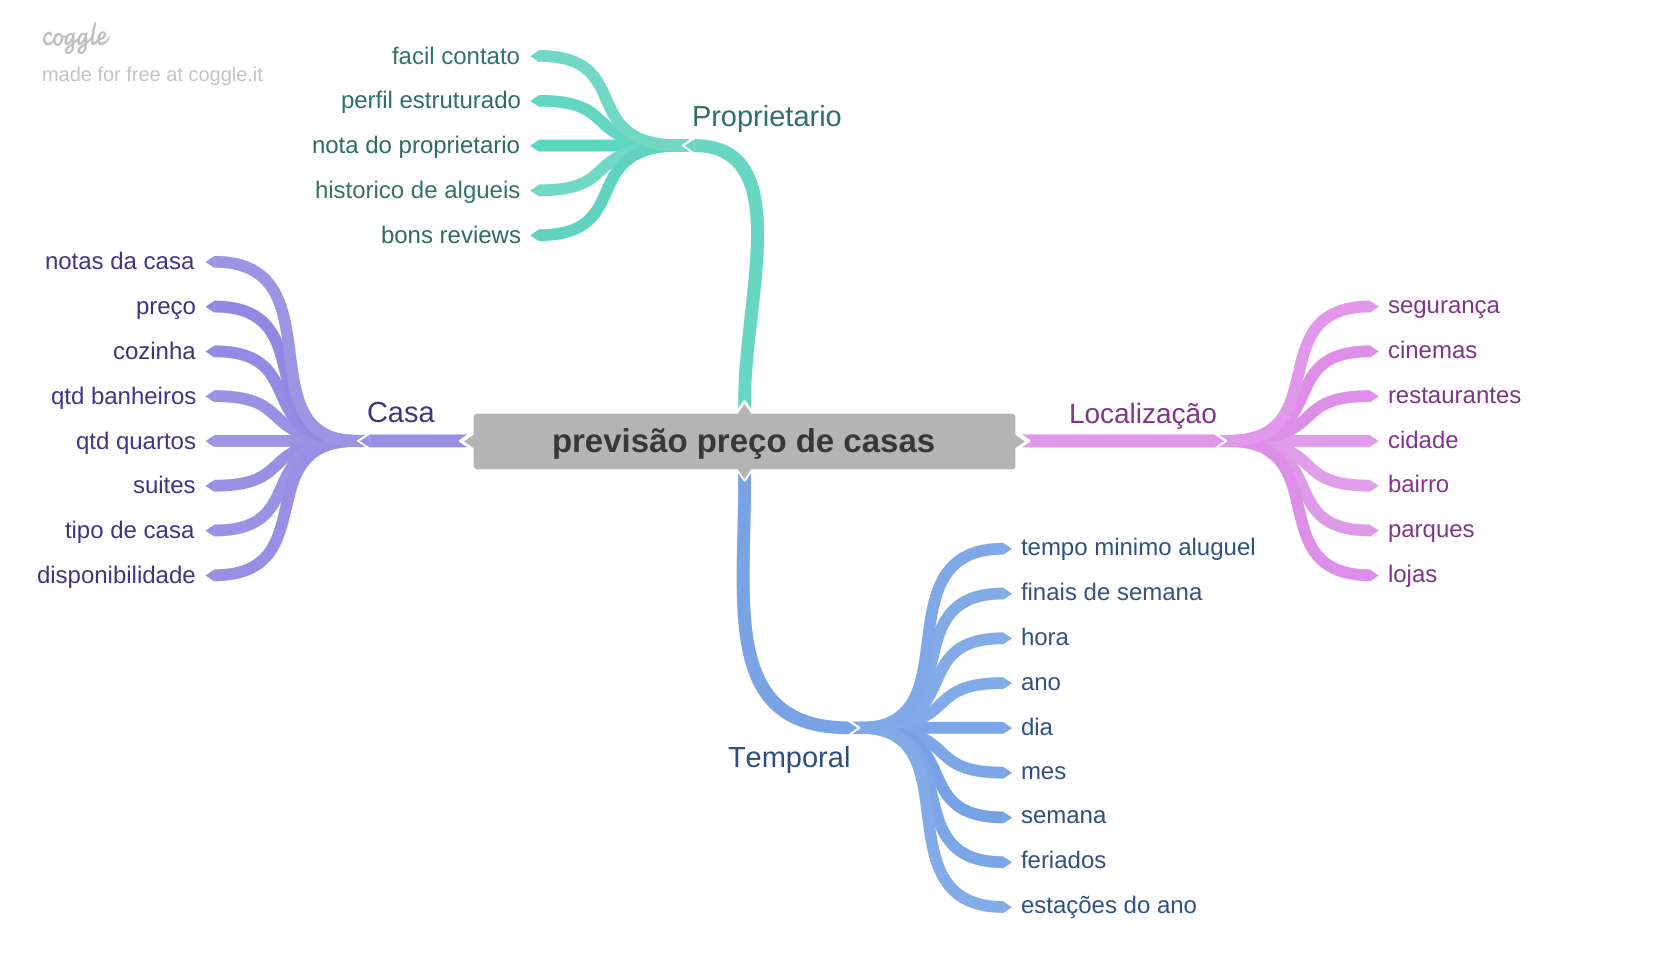

In [46]:
Image('../img/mind_map_preco_casa.png')

## 4.2. Criação de Hipóteses

### 4.2.1. Temporal

1. O preço das casas alugadas em periodo de feriados é mais alto
2. O preço das casas alugadas no inverno é mais caro
3. Casas com maior tempo de anuncio, tem o menor  numero de reviews
4. O preço das casas aumenta com o passar dos anos

### 4.2.2. Casa

1. Quantidade de quartos aumenta o preço da casa
2. Casas com maior tempo de disponibilidade, tem o mais numero_de_reviews
3. Apartamentos inteiros são mais caros que os outros tipos de casas
4. Casas com o menor preço são mais alugadas
5. Casas com maior quantidade de reviews tem preços maiores

### 4.2.3. Localização

1. Manhatam é o bairro mais caro
2. O tipo de casa menos comum no bairro tem o maior preço
3. Casas mais proximas a parques são mais caras
4. Bairros mais seguros tem casas mais caras
5. Bairros com maior quantidade de lojas, tem casas mais caras

## 4.3. Final List Hypotheses

1. Existe mais casas disponiveis com menos quantidade de noites exigidas para o aluguel
2. O preço das casas aumenta com o passar dos anos
3. Casas com maior tempo de anuncio, tem o menor  numero de reviews
4. Apartamentos inteiros são mais caros que os outros tipos de casas
5. Casas com maior quantidade de reviews tem preços maiores
6. Manhatam é o bairro mais caro


## 4.4. Saved Actual Data

In [47]:
path = '..\data\processed\df4_hypotesis_creation.csv'
df4.to_csv(path, index=False)

# 5.0. EDA

In [48]:
df5 = df4.copy()

In [49]:
df5.sample(5).T

,48197,22596,29235,4185,24057
id,36136048,18283136,22436581,2722693,19387694
nome,Manhattan ♥ 2BR apartment,Modern midtown studio,Beautiful bedroom in Manhattan,Luxury High Rise Near Central Park,Cool town house
host_id,270307751,44453334,110191144,3280997,14140453
host_name,Charles,Oleg,Mamadou,Scott,Mark
bairro_group,Manhattan,Manhattan,Manhattan,Manhattan,Brooklyn
bairro,Lower East Side,Hell's Kitchen,Harlem,Theater District,Carroll Gardens
latitude,40.71877,40.75383,40.82375,40.76351,40.68254
longitude,-73.99055,-73.99733,-73.95379,-73.98431,-73.99207
room_type,Entire home/apt,Shared room,Private room,Entire home/apt,Entire home/apt
price,320,145,68,250,450


## 5.1. Analise Univariada

### 5.1.1. Variavel Resposta

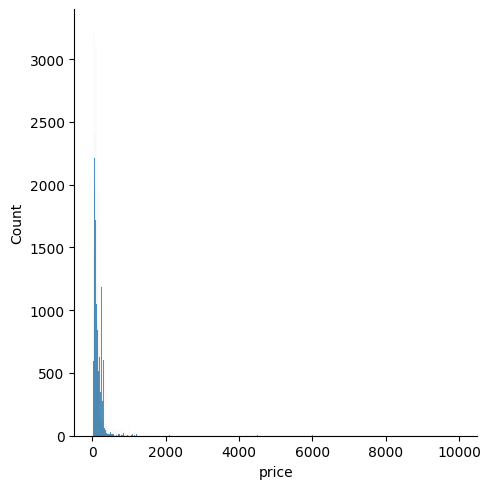

In [50]:
sns.displot(df5['price'])

### 5.1.2 Variaveis Numericas

In [51]:
get_descriptive_info(df5) 

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,2595.000000,3.648724e+07,3.648465e+07,1.901718e+07,1.967574e+07,1.098398e+07,-0.090161,-1.228130
1,host_id,2438.000000,2.743213e+08,2.743189e+08,6.762342e+07,3.079382e+07,7.861607e+07,1.206147,0.168670
2,latitude,40.499790,4.091306e+01,4.132700e-01,4.072895e+01,4.072308e+01,5.453053e-02,0.236900,0.148866
3,longitude,-74.244420,-7.371299e+01,5.314300e-01,-7.395218e+01,-7.395568e+01,4.615865e-02,1.284554,5.022419
4,price,10.000000,1.000000e+04,9.990000e+03,1.527551e+02,1.060000e+02,2.401703e+02,19.118830,585.624549
5,minimo_noites,1.000000,1.250000e+03,1.249000e+03,7.030010e+00,3.000000e+00,2.051221e+01,21.826614,853.969900
6,numero_de_reviews,0.000000,6.290000e+02,6.290000e+02,2.327228e+01,5.000000e+00,4.455128e+01,3.691156,19.533293
7,reviews_por_mes,-1.000000,5.850000e+01,5.950000e+01,8.852047e-01,3.700000e-01,1.778478e+00,2.453181,28.698600
8,calculado_host_listings_count,1.000000,3.270000e+02,3.260000e+02,7.144652e+00,1.000000e+00,3.295618e+01,7.932170,67.533287
9,disponibilidade_365,0.000000,3.650000e+02,3.650000e+02,1.127743e+02,4.500000e+01,1.316223e+02,0.763506,-0.997462


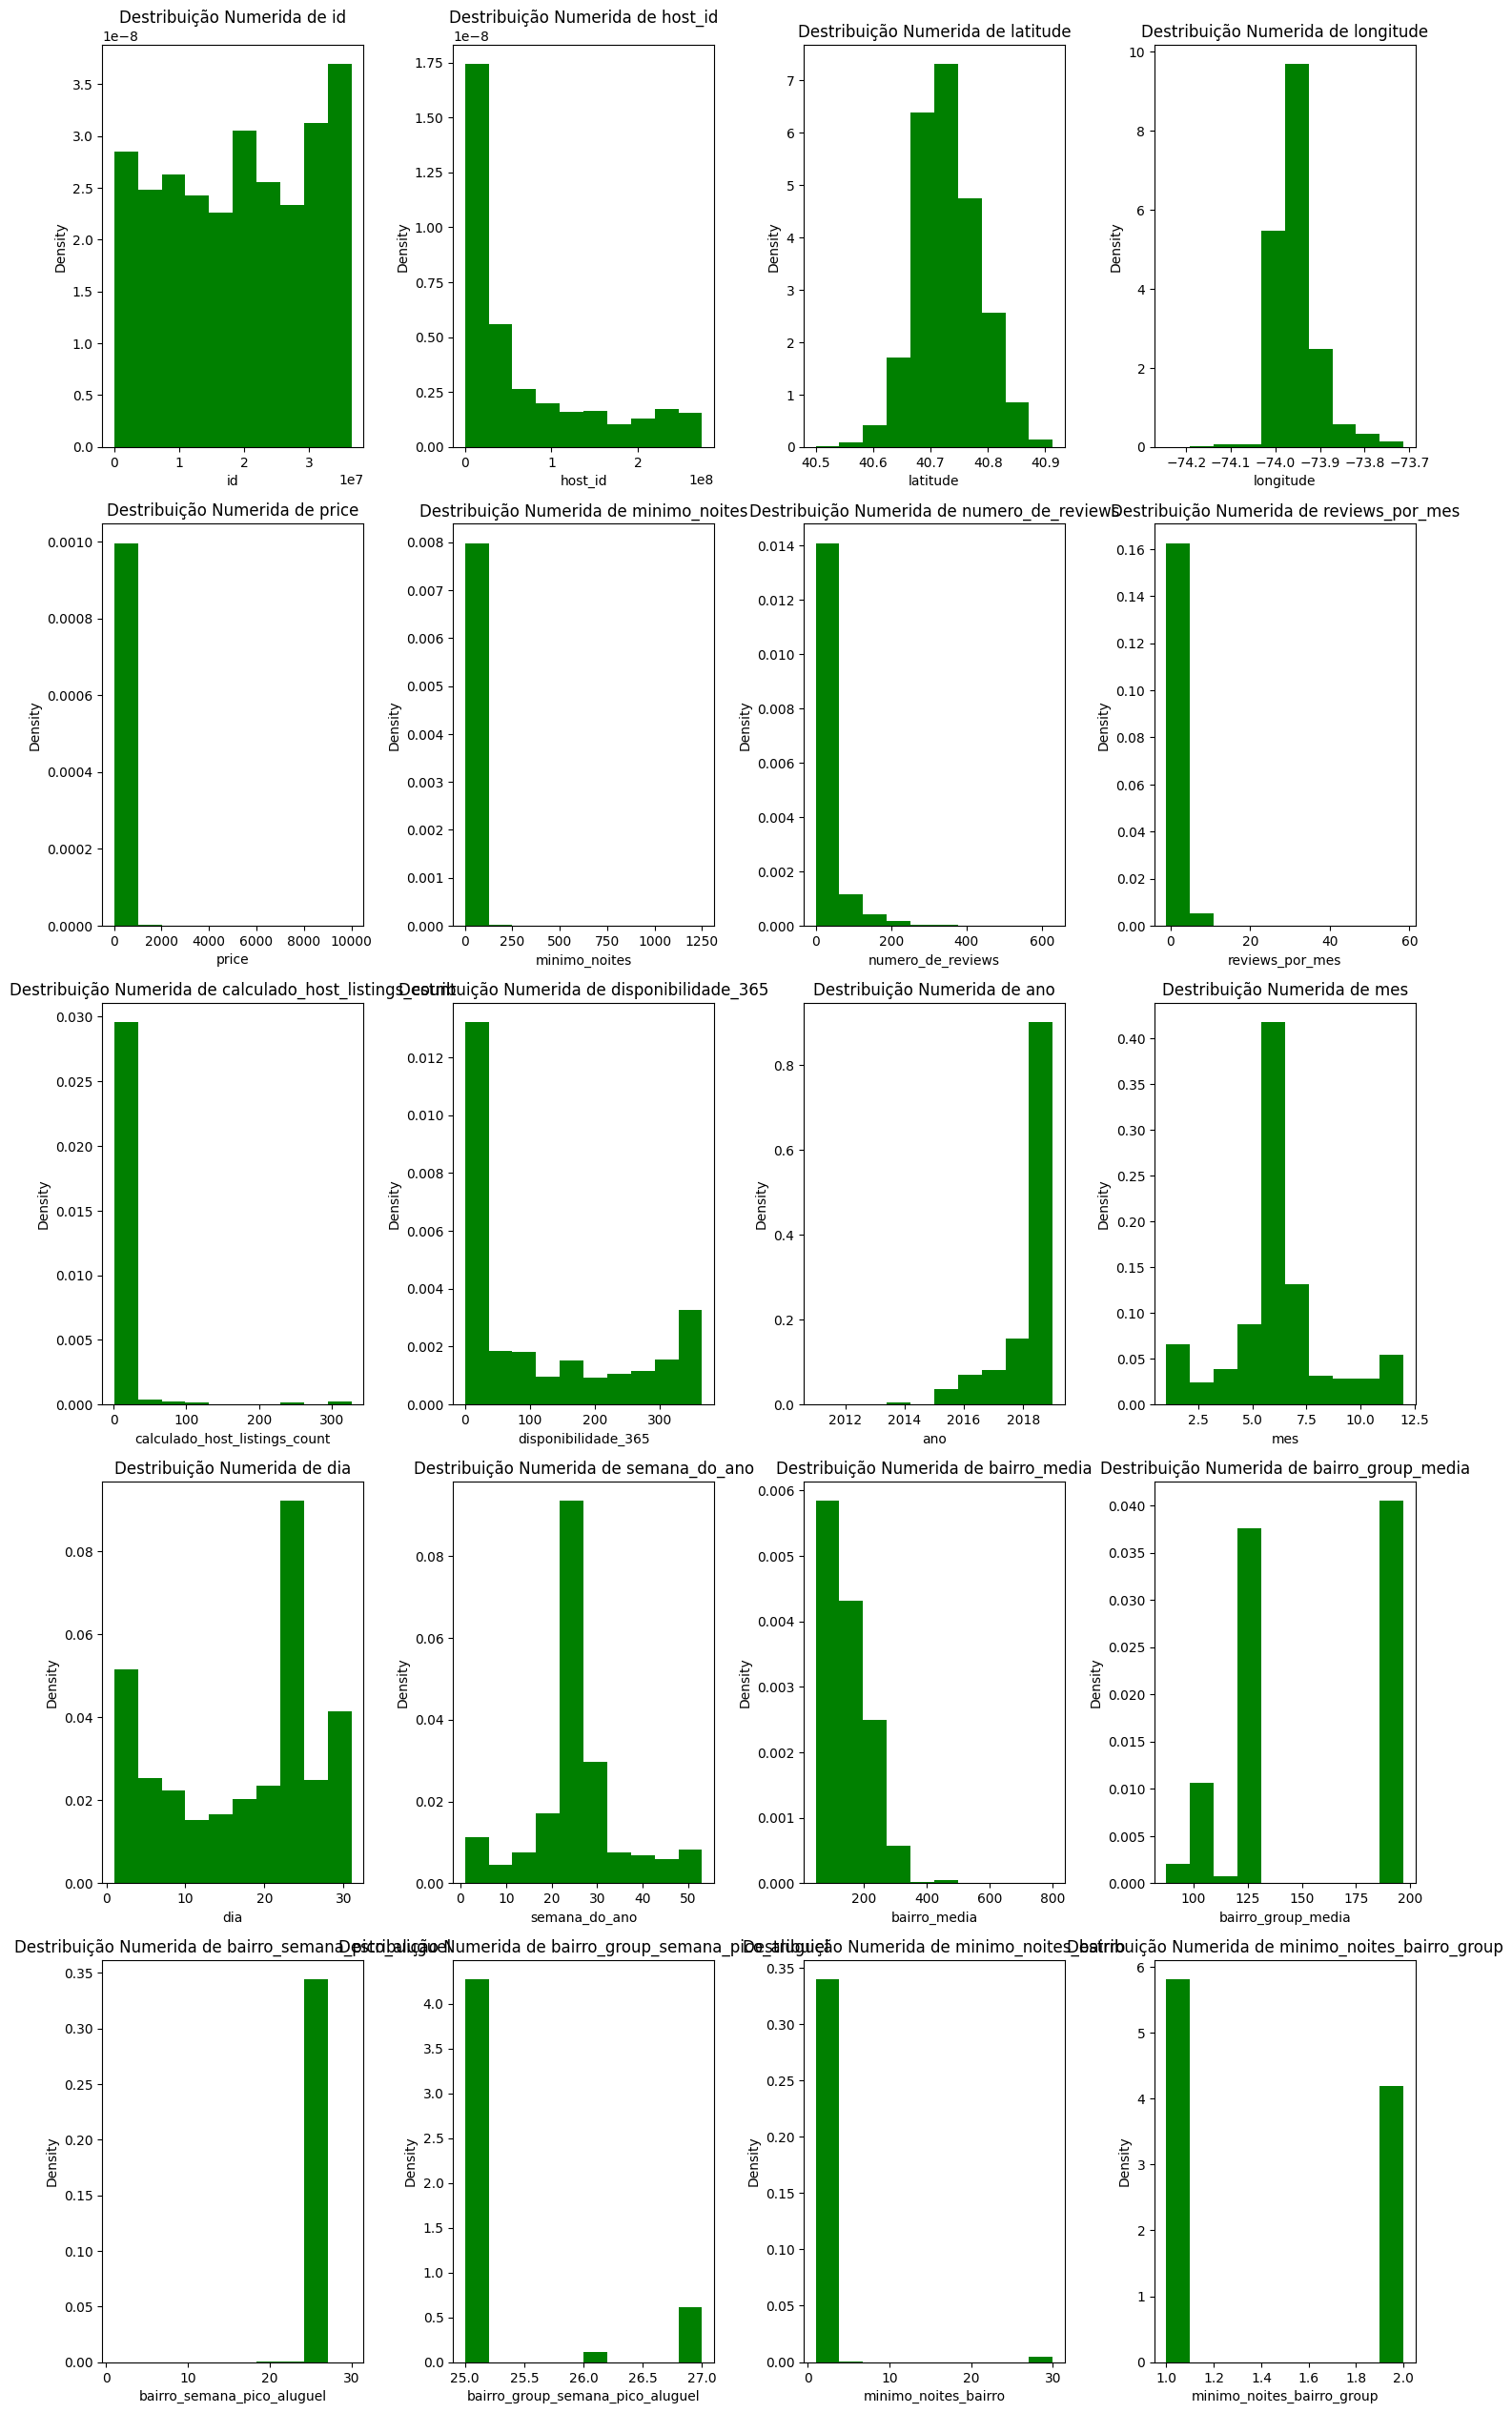

In [52]:
plot_numerical_distribution(df5)

In [53]:
df5['host_id'].value_counts().sort_index()

host_id
2438         1
2571         1
2787         5
2845         2
2868         1
            ..
274273284    1
274298453    1
274307600    1
274311461    1
274321313    1
Name: count, Length: 37455, dtype: int64

### 5.2.3 Variaveis Categoricas

In [54]:
get_categorical_attributes(df5).dtypes

nome                      object
host_name                 object
bairro_group              object
bairro                    object
room_type                 object
ano_semana                object
room_type_bairro          object
room_type_bairro_group    object
dtype: object

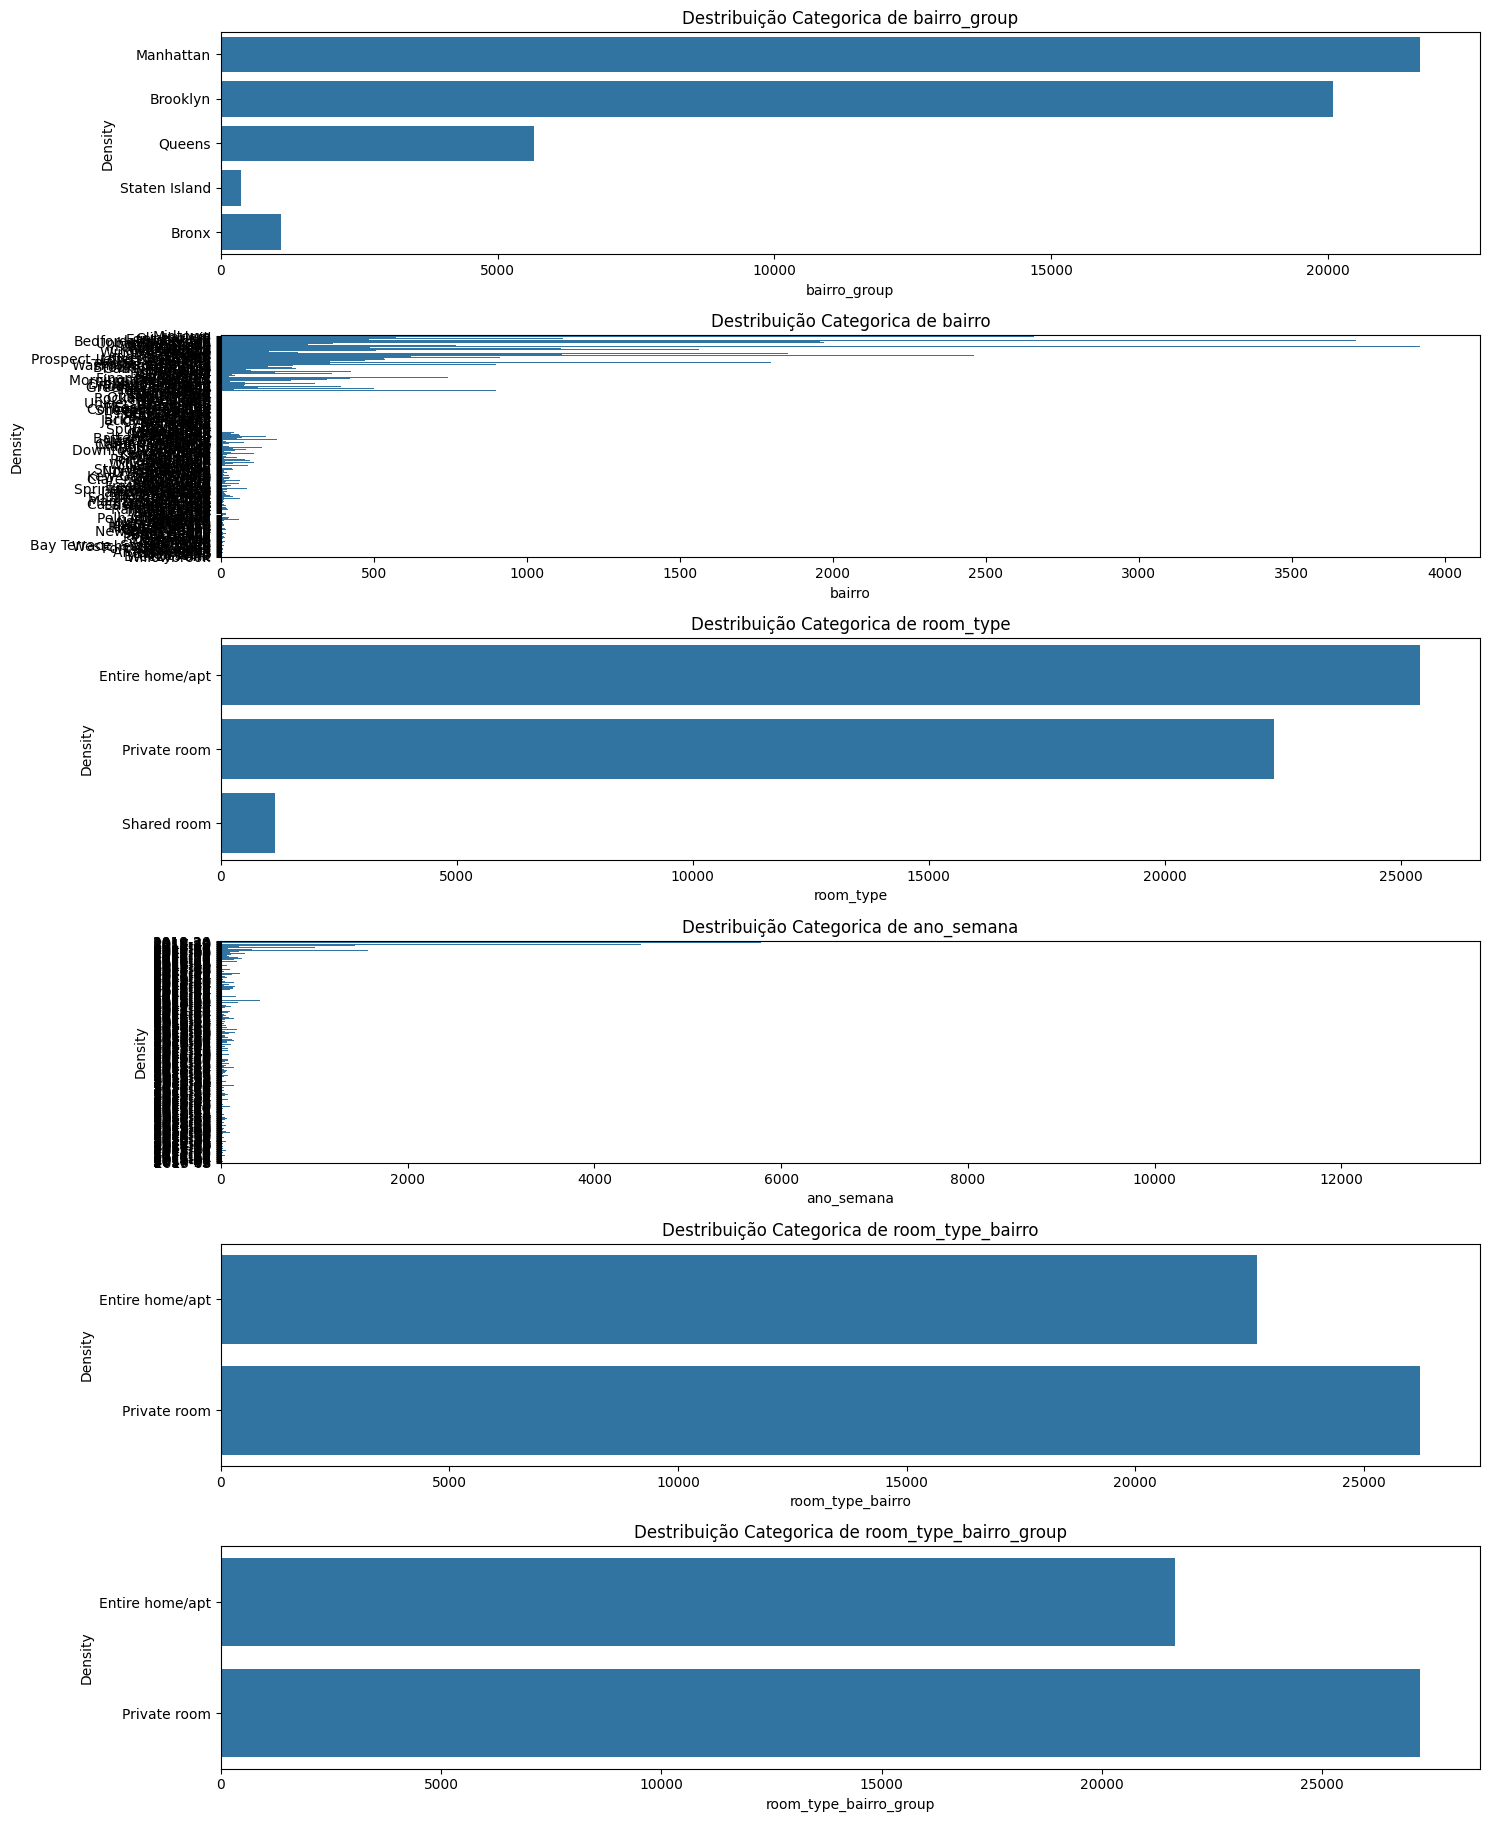

In [55]:
plot_categorical_distribution(df5.drop(columns=['nome', 'host_name']))

## 5.2. Analise Bivariada

### 5.2.1. Hipotese 1

1. Existe mais casas disponiveis com menos quantidade de noites exigidas para o aluguel

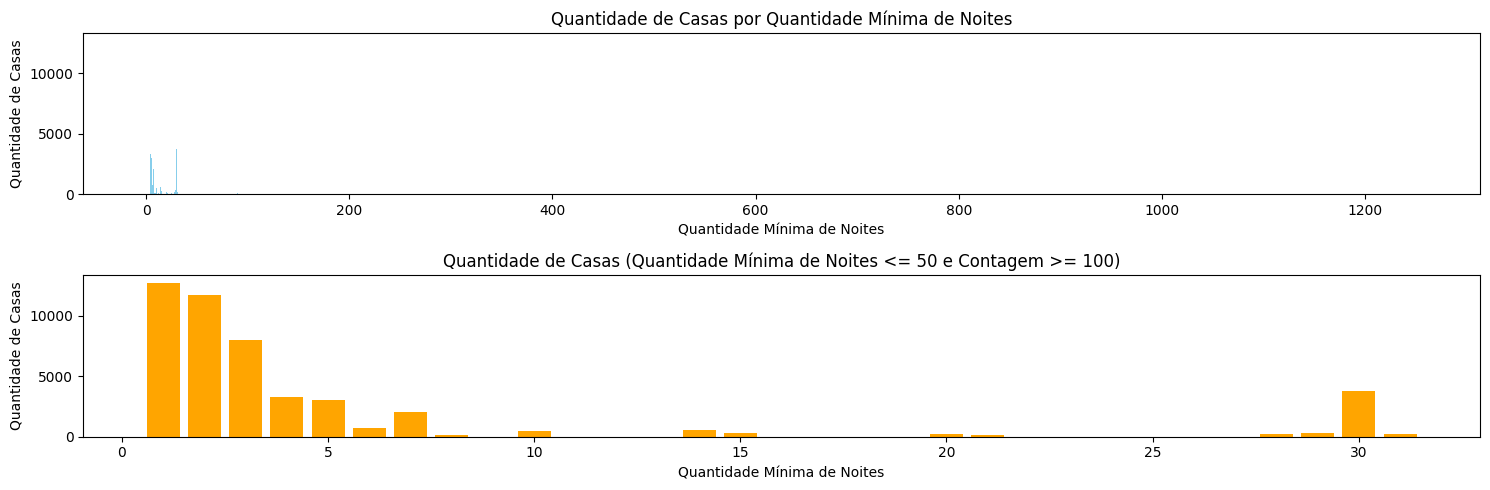

In [56]:
plt.figure(figsize=(15, 5))

# Subplot 1 - Quantidade de casas por quantidade mínima de noites
plt.subplot(2, 1, 1)
quantidade_casas_por_noite = df5['minimo_noites'].value_counts().sort_index()
plt.bar(quantidade_casas_por_noite.index, quantidade_casas_por_noite.values, color='skyblue')
plt.title('Quantidade de Casas por Quantidade Mínima de Noites')
plt.xlabel('Quantidade Mínima de Noites')
plt.ylabel('Quantidade de Casas')

# Subplot 2 - Contagem de entradas filtradas (<= 50 e >= 100)
plt.subplot(2, 1, 2)
filtro = (quantidade_casas_por_noite.index <= 50) & (quantidade_casas_por_noite.values >= 100)
quantidade_casas_por_noite_filtrado = quantidade_casas_por_noite[filtro]
plt.bar(quantidade_casas_por_noite_filtrado.index, quantidade_casas_por_noite_filtrado.values, color='orange')
plt.title('Quantidade de Casas (Quantidade Mínima de Noites <= 50 e Contagem >= 100)')
plt.xlabel('Quantidade Mínima de Noites')
plt.ylabel('Quantidade de Casas')

plt.tight_layout()
plt.show()

### 5.2.2. Hipotese 2

2. O preço das casas aumenta com o passar dos anos

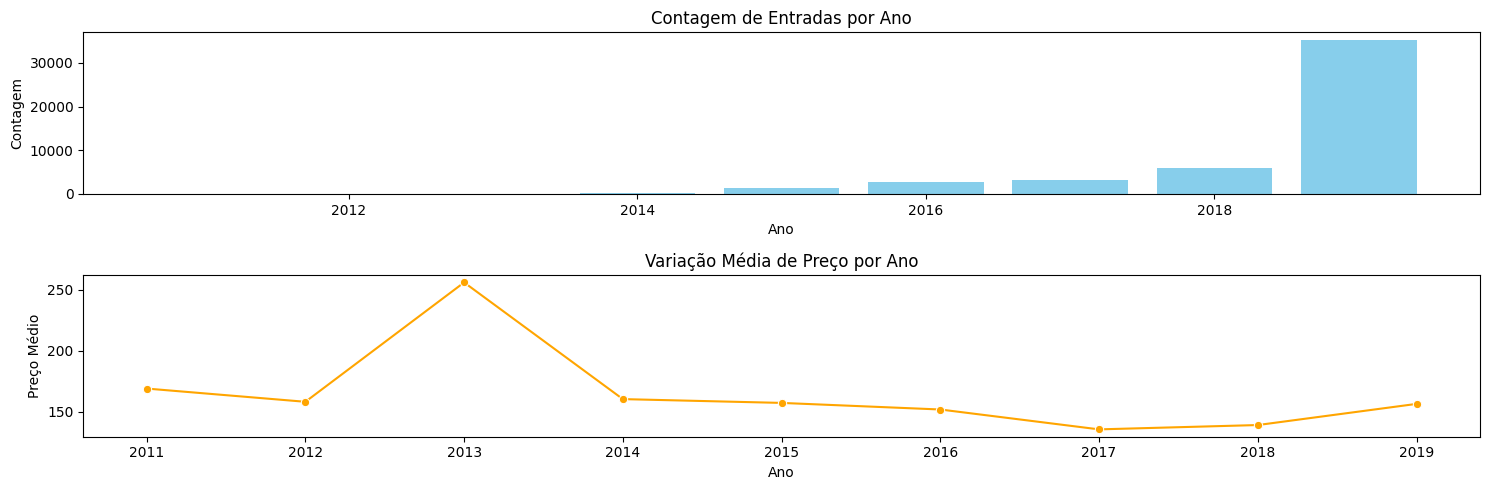

In [57]:
plt.figure(figsize=(15, 5))

# Subplot 1 - Contagem de entradas por ano
plt.subplot(2, 1, 1)
aux1 = df5['ano'].value_counts().sort_index()
plt.bar(aux1.index, aux1.values, color='skyblue')
plt.title('Contagem de Entradas por Ano')
plt.xlabel('Ano')
plt.ylabel('Contagem')

# Subplot 2 - Variação média de preço por ano
plt.subplot(2, 1, 2)
aux2 = df5.groupby('ano')['price'].mean().reset_index()
sns.lineplot(x='ano', y='price', data=aux2, marker='o', color='orange')
plt.title('Variação Média de Preço por Ano')
plt.xlabel('Ano')
plt.ylabel('Preço Médio')

plt.tight_layout()
plt.show()


### 5.2.3. Hipotese 3

3. Casas com maior tempo de anuncio, tem o menor  numero de reviews

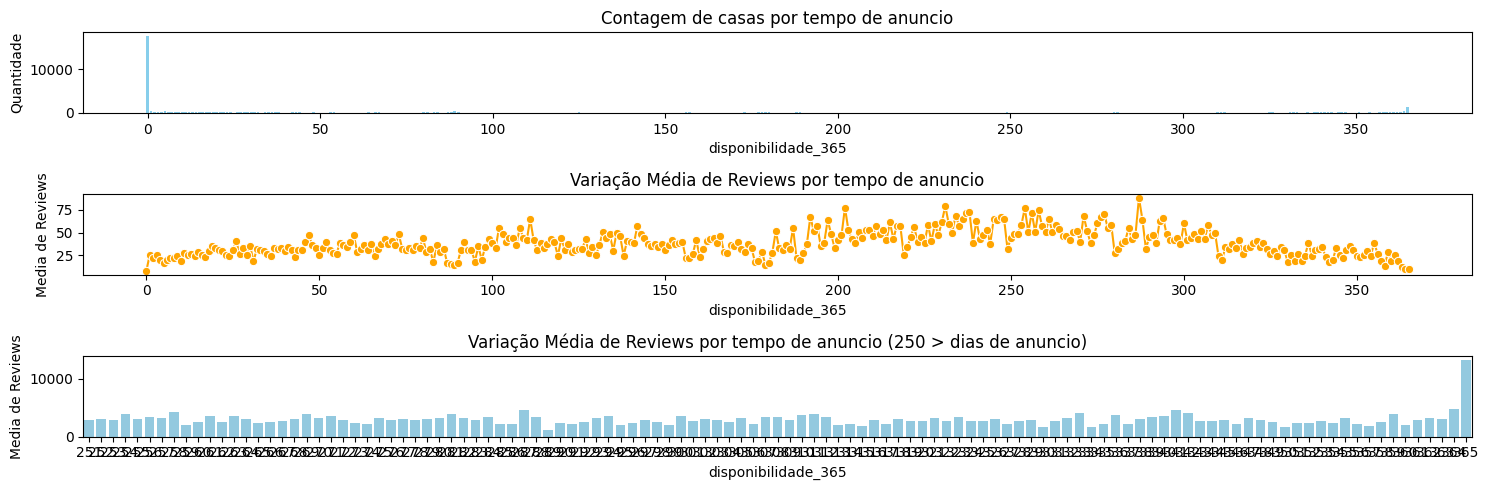

In [58]:
plt.figure(figsize=(15, 5))

# Subplot 1 - Quantidade de casas por tempo de anuncio
plt.subplot(3, 1, 1)
aux1 = df5['disponibilidade_365'].value_counts().sort_index()
plt.bar(aux1.index, aux1.values, color='skyblue')
plt.title('Contagem de casas por tempo de anuncio')
plt.xlabel('disponibilidade_365')
plt.ylabel('Quantidade')

# Subplot 2 - Variação Média de Reviews por tempo de anuncio
plt.subplot(3, 1, 2)
aux2 = df5.groupby('disponibilidade_365')['numero_de_reviews'].mean().reset_index()
sns.lineplot(x='disponibilidade_365', y='numero_de_reviews', data=aux2, marker='o', color='orange')
plt.title('Variação Média de Reviews por tempo de anuncio')
plt.xlabel('disponibilidade_365')
plt.ylabel('Media de Reviews')

# Subplot 3 - Variação Média de Reviews por tempo de anuncio filtro com dias > 250
plt.subplot(3, 1, 3)
aux1 = df5[['disponibilidade_365', 'numero_de_reviews']].groupby(['disponibilidade_365']).sum().reset_index()
aux1 = aux1[(aux1['disponibilidade_365'] > 250)]
sns.barplot(x='disponibilidade_365', y='numero_de_reviews', data=aux1, color='skyblue');
plt.title('Variação Média de Reviews por tempo de anuncio (250 > dias de anuncio)')
plt.xlabel('disponibilidade_365')
plt.ylabel('Media de Reviews')


plt.tight_layout()
plt.show()


### 5.2.4. Hipotese 4

4. Apartamentos inteiros são mais caros que os outros tipos de casas

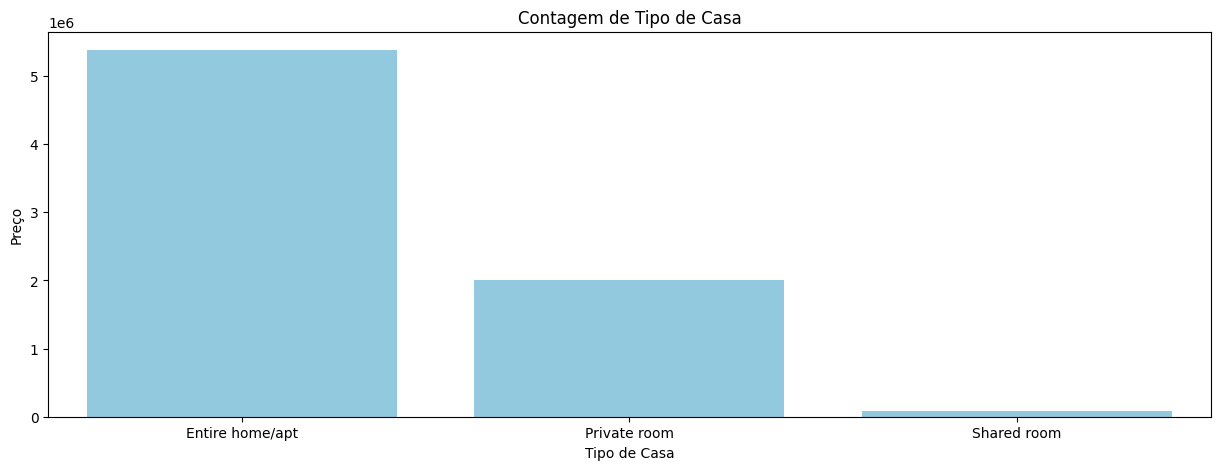

In [59]:
plt.figure(figsize=(15, 5))
# Plot 1 - Soma total do Tipo de Casa 
aux1 = df5[['room_type', 'price']].groupby('room_type').sum().reset_index()
sns.barplot(x='room_type', y='price', data=aux1, color='skyblue');
plt.title('Contagem de Tipo de Casa')
plt.xlabel('Tipo de Casa')
plt.ylabel('Preço')
plt.show()

Text(0, 0.5, 'Price')

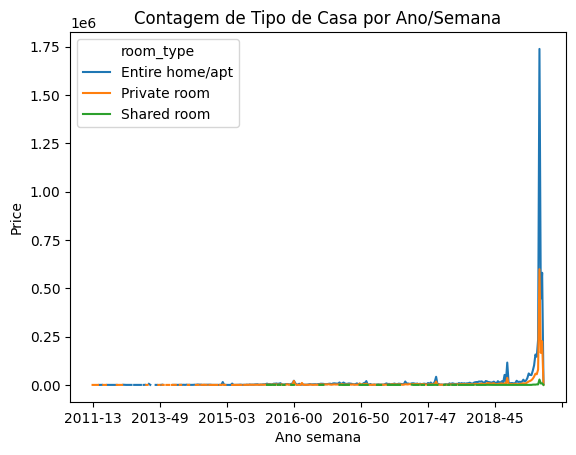

In [60]:
aux2 = df5[['ano_semana', 'room_type', 'price']].groupby(['ano_semana','room_type']).sum().reset_index()
aux2.pivot(index='ano_semana', columns='room_type', values='price').plot()
plt.title('Contagem de Tipo de Casa por Ano/Semana')
plt.xlabel('Ano semana')
plt.ylabel('Price')

### 5.2.5. Hipotese 5

5. Casas com maior quantidade de reviews tem preços maiores

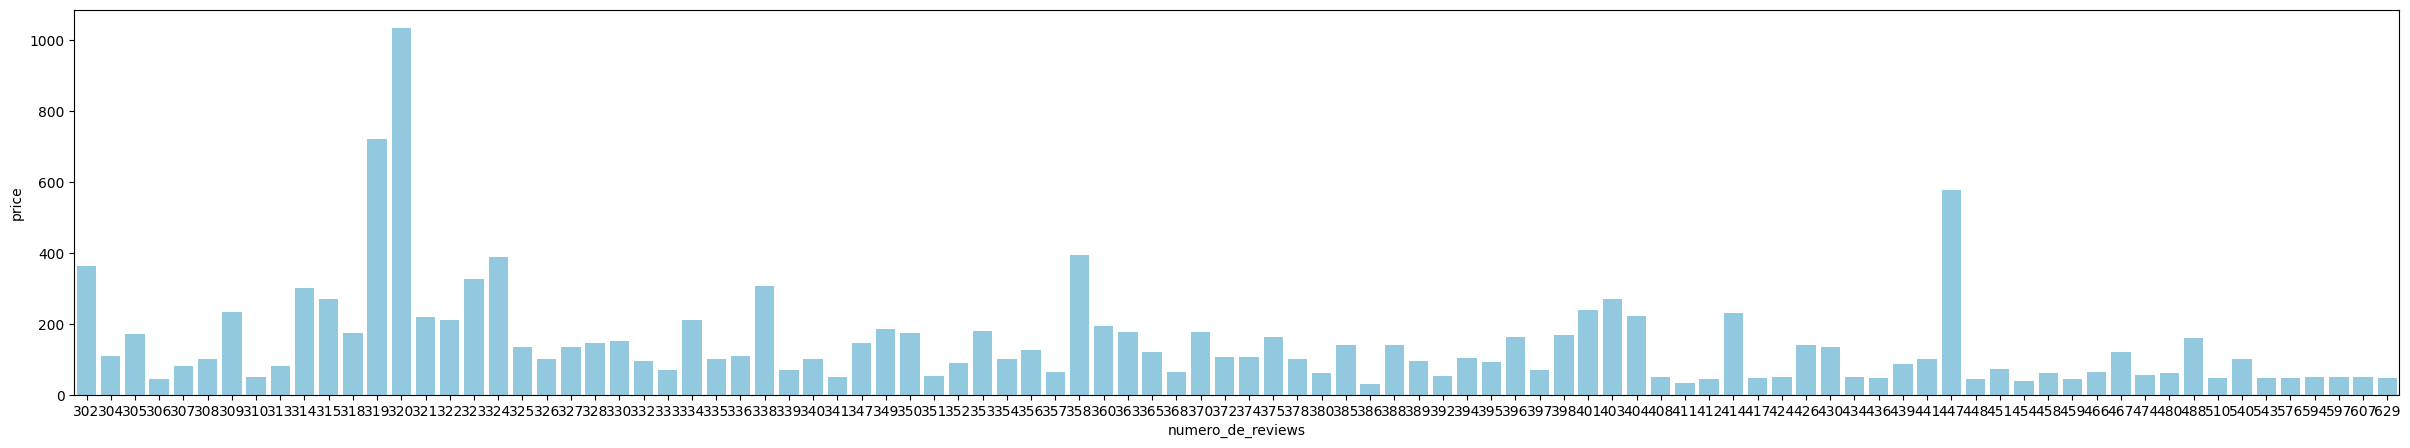

In [61]:
# Plot 1 - Soma total do Tipo de Casa 
plt.figure(figsize=(30,5))
aux1 = df5[['numero_de_reviews', 'price']].groupby(['numero_de_reviews']).sum().reset_index()
aux1 = aux1[(aux1['numero_de_reviews'] > 300) & (aux1['numero_de_reviews'] != 0)]
sns.barplot(x='numero_de_reviews', y='price', data=aux1, color='skyblue');
plt.show()

### 5.2.6. Hipotese 6

6. Manhatam é o bairro mais caro

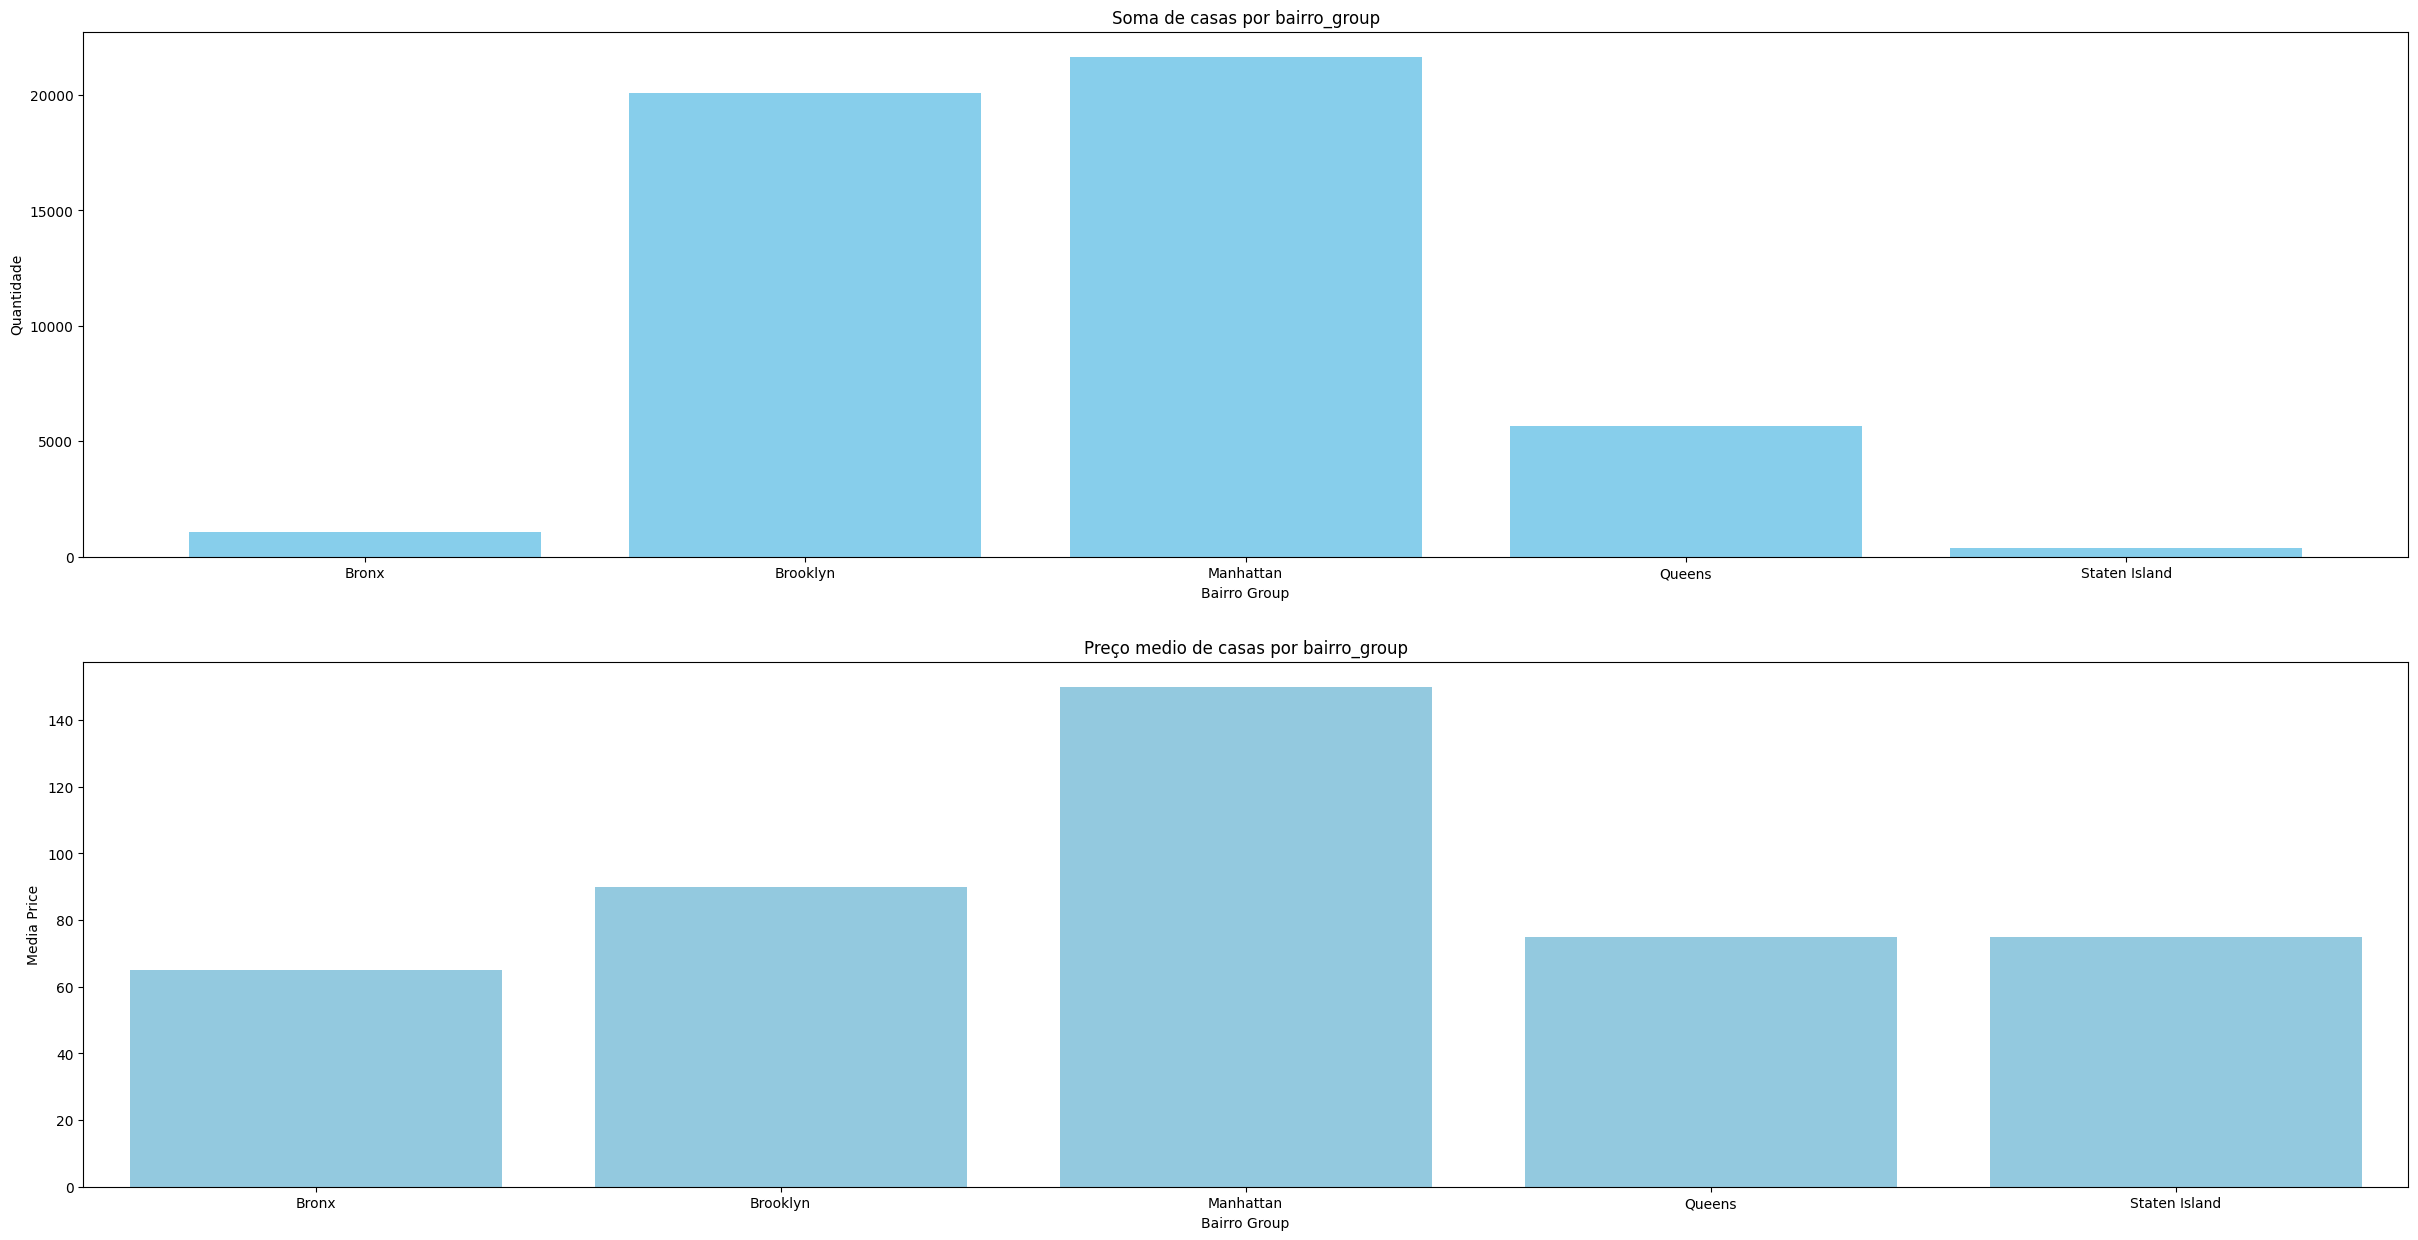

In [62]:
plt.figure(figsize=(30,15))

# Plot 1 - Soma total de casas por bairro_group
plt.subplot(2, 1, 1)
aux1 = df5['bairro_group'].value_counts().sort_index()
plt.bar(aux1.index, aux1.values, color='skyblue')
plt.title('Soma de casas por bairro_group')
plt.xlabel('Bairro Group')
plt.ylabel('Quantidade')

# Plot 2 - Preço medio de casas por bairro_group
plt.subplot(2, 1, 2)
aux1 = df5[['bairro_group', 'price']].groupby(['bairro_group']).median().reset_index()
sns.barplot(x='bairro_group', y='price', data=aux1, color='skyblue');
plt.title('Preço medio de casas por bairro_group')
plt.xlabel('Bairro Group')
plt.ylabel('Media Price')

plt.show()

## 5.3. Analise Multivariada

### 5.3.1. Numerical Attributes

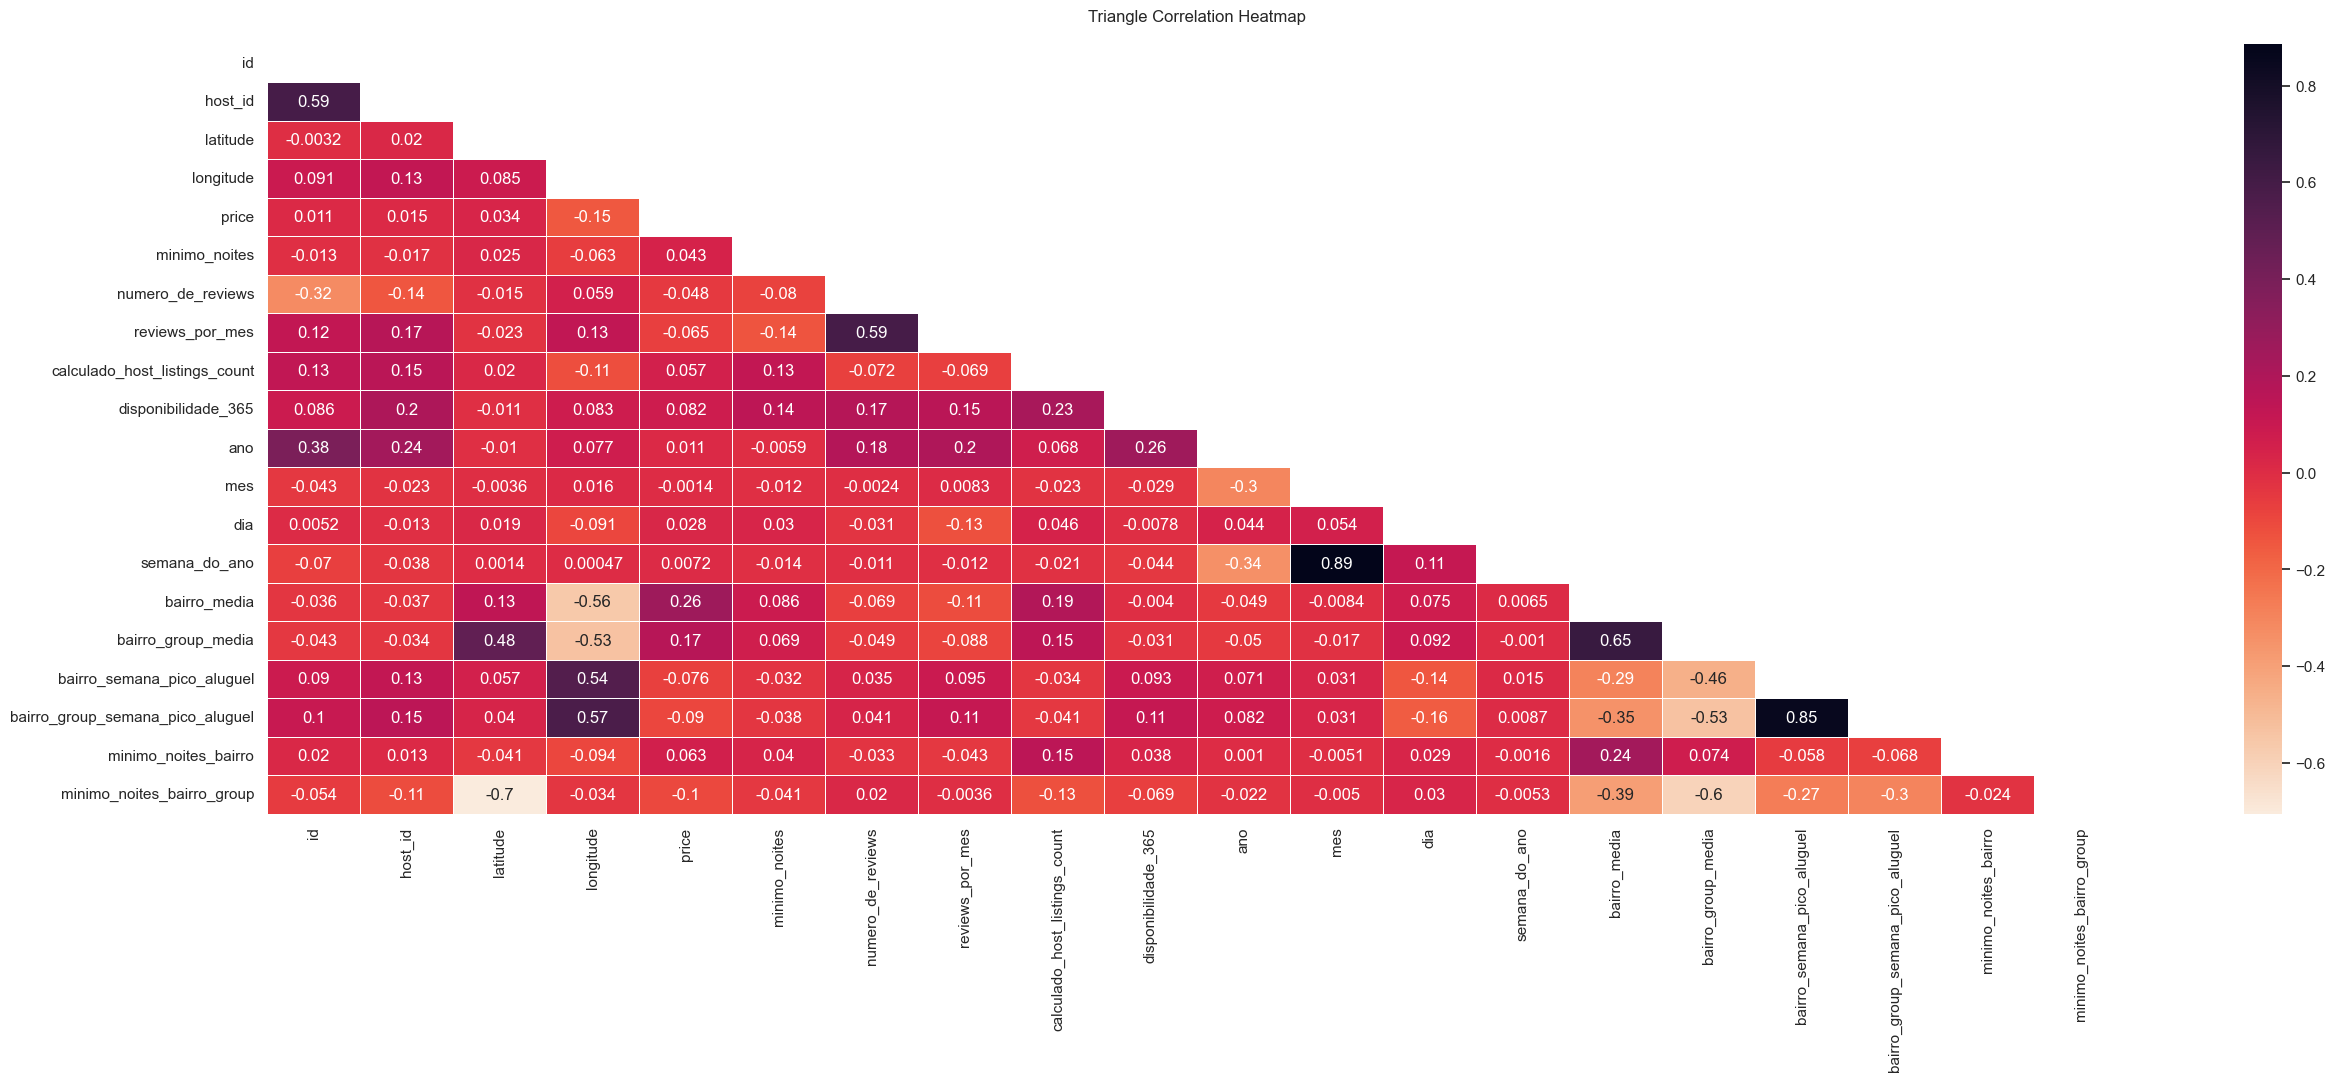

In [63]:
num_attributes = get_numerical_attributes(df5)
plot_triangle_correlation_heatmap(num_attributes.corr(method='pearson'))

### 5.3.2. Categorical Attributes

In [64]:
cat_attributes = get_categorical_attributes(df5)
cat_attributes.columns

Index(['nome', 'host_name', 'bairro_group', 'bairro', 'room_type',
       'ano_semana', 'room_type_bairro', 'room_type_bairro_group'],
      dtype='object')

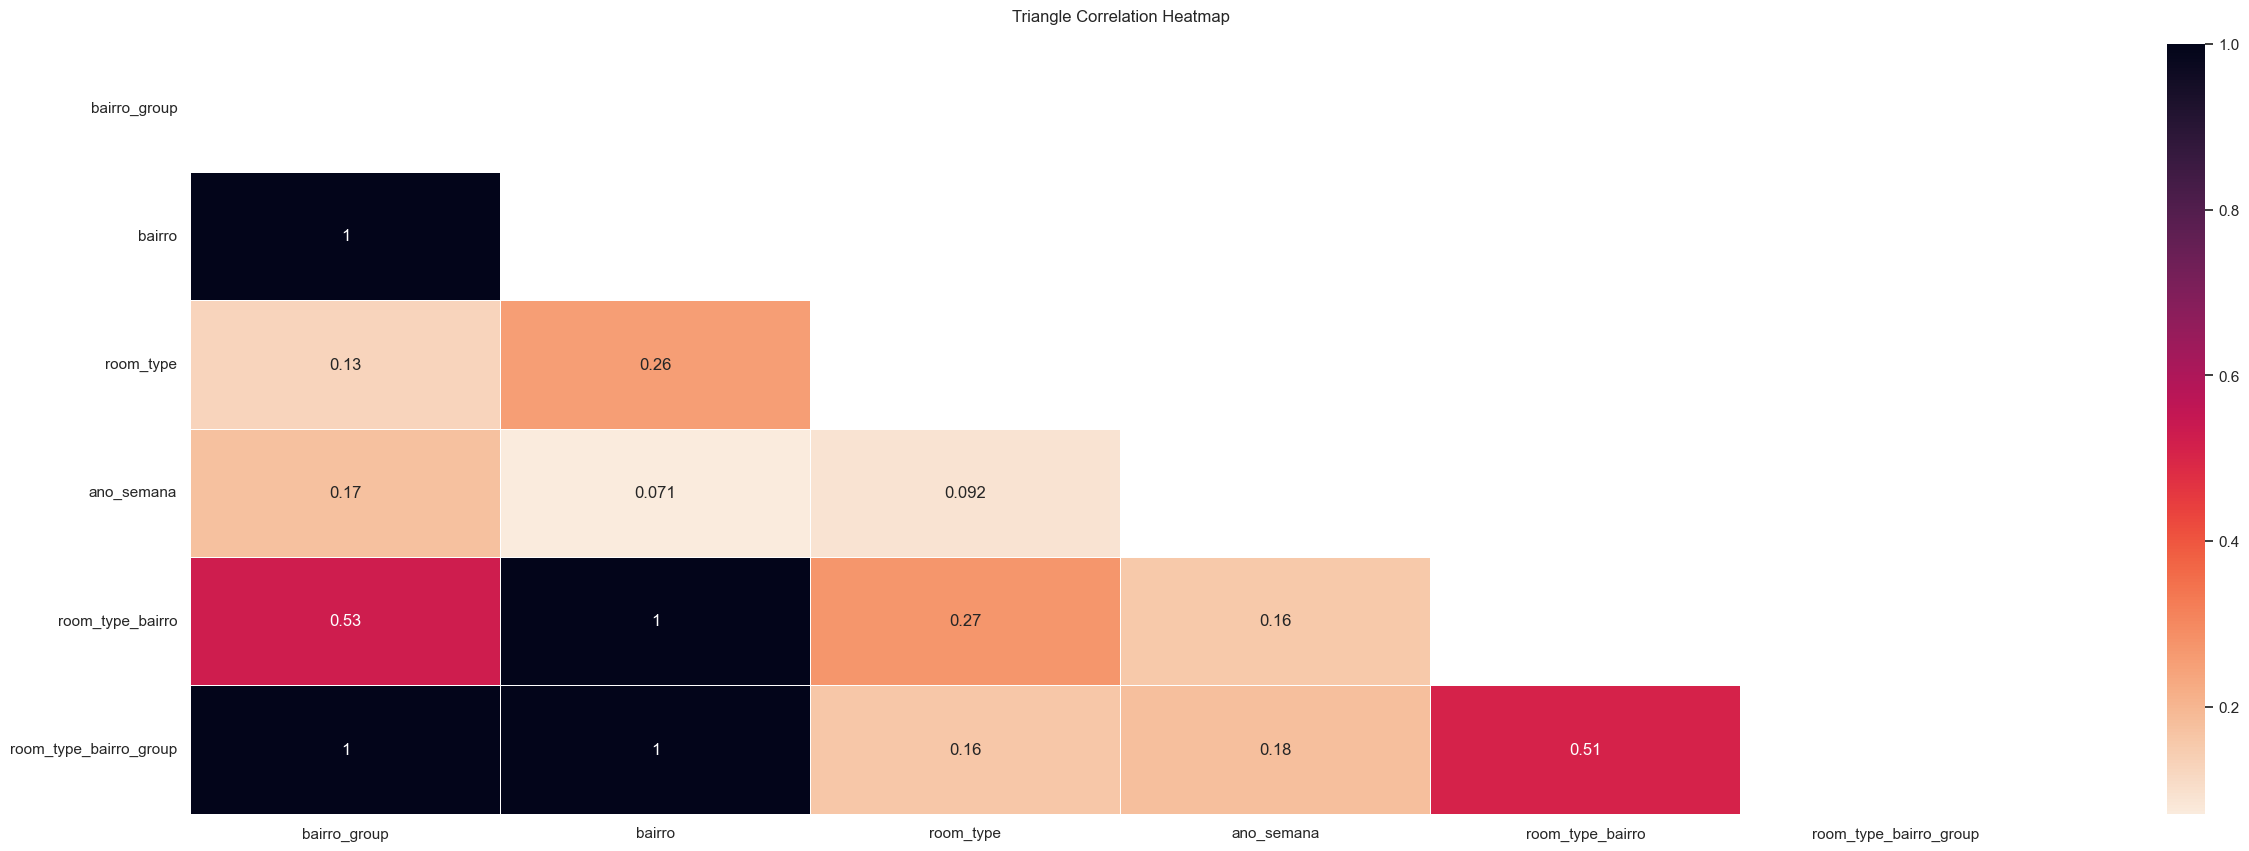

In [65]:
a1 = cramer_v(cat_attributes['bairro_group'], cat_attributes['bairro_group'])
a2 = cramer_v(cat_attributes['bairro_group'], cat_attributes['bairro'])
a3 = cramer_v(cat_attributes['bairro_group'], cat_attributes['room_type'])
a4 = cramer_v(cat_attributes['bairro_group'], cat_attributes['ano_semana'])
a5 = cramer_v(cat_attributes['bairro_group'], cat_attributes['room_type_bairro'])
a6 = cramer_v(cat_attributes['bairro_group'], cat_attributes['room_type_bairro_group'])

b1 = cramer_v(cat_attributes['bairro'], cat_attributes['bairro_group'])
b2 = cramer_v(cat_attributes['bairro'], cat_attributes['bairro'])
b3 = cramer_v(cat_attributes['bairro'], cat_attributes['room_type'])
b4 = cramer_v(cat_attributes['bairro'], cat_attributes['ano_semana'])
b5 = cramer_v(cat_attributes['bairro'], cat_attributes['room_type_bairro'])
b6 = cramer_v(cat_attributes['bairro'], cat_attributes['room_type_bairro_group'])

c1 = cramer_v(cat_attributes['room_type'], cat_attributes['bairro_group'])
c2 = cramer_v(cat_attributes['room_type'], cat_attributes['bairro'])
c3 = cramer_v(cat_attributes['room_type'], cat_attributes['room_type'])
c4 = cramer_v(cat_attributes['room_type'], cat_attributes['ano_semana'])
c5 = cramer_v(cat_attributes['room_type'], cat_attributes['room_type_bairro'])
c6 = cramer_v(cat_attributes['room_type'], cat_attributes['room_type_bairro_group'])

d1 = cramer_v(cat_attributes['ano_semana'], cat_attributes['bairro_group'])
d2 = cramer_v(cat_attributes['ano_semana'], cat_attributes['bairro'])
d3 = cramer_v(cat_attributes['ano_semana'], cat_attributes['room_type'])
d4 = cramer_v(cat_attributes['ano_semana'], cat_attributes['ano_semana'])
d5 = cramer_v(cat_attributes['ano_semana'], cat_attributes['room_type_bairro'])
d6 = cramer_v(cat_attributes['ano_semana'], cat_attributes['room_type_bairro_group'])

e1 = cramer_v(cat_attributes['room_type_bairro'], cat_attributes['bairro_group'])
e2 = cramer_v(cat_attributes['room_type_bairro'], cat_attributes['bairro'])
e3 = cramer_v(cat_attributes['room_type_bairro'], cat_attributes['room_type'])
e4 = cramer_v(cat_attributes['room_type_bairro'], cat_attributes['ano_semana'])
e5 = cramer_v(cat_attributes['room_type_bairro'], cat_attributes['room_type_bairro'])
e6 = cramer_v(cat_attributes['room_type_bairro'], cat_attributes['room_type_bairro_group'])

f1 = cramer_v(cat_attributes['room_type_bairro_group'], cat_attributes['bairro_group'])
f2 = cramer_v(cat_attributes['room_type_bairro_group'], cat_attributes['bairro'])
f3 = cramer_v(cat_attributes['room_type_bairro_group'], cat_attributes['room_type'])
f4 = cramer_v(cat_attributes['room_type_bairro_group'], cat_attributes['ano_semana'])
f5 = cramer_v(cat_attributes['room_type_bairro_group'], cat_attributes['room_type_bairro'])
f6 = cramer_v(cat_attributes['room_type_bairro_group'], cat_attributes['room_type_bairro_group'])

cat_df = pd.DataFrame({'bairro_group': [a1, a2, a3, a4, a5, a6],
                       'bairro': [b1, b2, b3, b4, b5, b6],
                       'room_type': [c1, c2, c3, c4, c5, c6],
                       'ano_semana': [d1, d2, d3, d4, d5, d6],
                       'room_type_bairro': [e1, e2, e3, e4, e5, e6],
                       'room_type_bairro_group': [f1, f2, f3, f4, f5, f6]})

cat_df = cat_df.set_index(cat_df.columns)

plot_triangle_correlation_heatmap(cat_df)

## 5.4. Saved Actual Data

In [66]:
path = '..\data\processed\df5_exploratory_data_analysis.csv'
df5.to_csv(path, index=False)

# 6.0. DATA PREPARATION

In [67]:
df6 = df5.copy()

In [68]:
df6.sample(5).T

,25973,41688,19787,1254,4936
id,20743703,32409562,15844840,536578,3539618
nome,Home away from home in Brooklyn,Sofa-bed in apartment in Astoria! Near Manhattan!,Room in Queens Close to Train Station!,Nice and clean private space in Bklyn loft.,Large modern studio in Gramercy
host_id,20866359,243367528,98697139,2635819,506909
host_name,Sarah,Lucca & Paula,Oscar,Fabrizio,Nevena
bairro_group,Brooklyn,Queens,Queens,Brooklyn,Manhattan
bairro,Crown Heights,Astoria,Corona,Bushwick,Kips Bay
latitude,40.67542,40.76466,40.7507,40.7014,40.73788
longitude,-73.95107,-73.91274,-73.85774,-73.91333,-73.98048
room_type,Private room,Shared room,Private room,Private room,Entire home/apt
price,50,40,40,59,170


In [69]:
get_descriptive_info(df6)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,2595.000000,3.648724e+07,3.648465e+07,1.901718e+07,1.967574e+07,1.098398e+07,-0.090161,-1.228130
1,host_id,2438.000000,2.743213e+08,2.743189e+08,6.762342e+07,3.079382e+07,7.861607e+07,1.206147,0.168670
2,latitude,40.499790,4.091306e+01,4.132700e-01,4.072895e+01,4.072308e+01,5.453053e-02,0.236900,0.148866
3,longitude,-74.244420,-7.371299e+01,5.314300e-01,-7.395218e+01,-7.395568e+01,4.615865e-02,1.284554,5.022419
4,price,10.000000,1.000000e+04,9.990000e+03,1.527551e+02,1.060000e+02,2.401703e+02,19.118830,585.624549
5,minimo_noites,1.000000,1.250000e+03,1.249000e+03,7.030010e+00,3.000000e+00,2.051221e+01,21.826614,853.969900
6,numero_de_reviews,0.000000,6.290000e+02,6.290000e+02,2.327228e+01,5.000000e+00,4.455128e+01,3.691156,19.533293
7,reviews_por_mes,-1.000000,5.850000e+01,5.950000e+01,8.852047e-01,3.700000e-01,1.778478e+00,2.453181,28.698600
8,calculado_host_listings_count,1.000000,3.270000e+02,3.260000e+02,7.144652e+00,1.000000e+00,3.295618e+01,7.932170,67.533287
9,disponibilidade_365,0.000000,3.650000e+02,3.650000e+02,1.127743e+02,4.500000e+01,1.316223e+02,0.763506,-0.997462


## 6.1. Normalization

Não há nenum dado numerico em estado gausiano, o que me leva a não utilizar normalização dos dados.

## 6.2. Rescaling

In [70]:
rs = RobustScaler()
mms = MinMaxScaler()

# minimo_noites - MinMaxScaler
df6['minimo_noites'] = mms.fit_transform(df6[['minimo_noites']].values)

# numero_de_reviews - RobustScaler
df6['numero_de_reviews'] = rs.fit_transform(df6[['numero_de_reviews']].values)

# reviews_por_mes - RobustScaler
df6['reviews_por_mes'] = rs.fit_transform(df6[['reviews_por_mes']].values)

# calculado_host_listings_count - RobustScaler
df6['calculado_host_listings_count'] = rs.fit_transform(df6[['calculado_host_listings_count']].values)

# disponibilidade_365 - MinMaxScaler
df6['disponibilidade_365'] = mms.fit_transform(df6[['disponibilidade_365']].values)

# ano - RobustScaler
df6['ano'] = rs.fit_transform(df6[['ano']].values)

# bairro_media - RobustScaler
df6['bairro_media'] = rs.fit_transform(df6[['bairro_media']].values)

# bairro_group_media - MinMaxScaler
df6['bairro_group_media'] = mms.fit_transform(df6[['bairro_group_media']].values)

# bairro_semana_pico_aluguel - RobustScaler
df6['bairro_semana_pico_aluguel'] = rs.fit_transform(df6[['bairro_semana_pico_aluguel']].values)

# bairro_group_semana_pico_aluguel - RobustScaler
df6['bairro_group_semana_pico_aluguel'] = rs.fit_transform(df6[['bairro_group_semana_pico_aluguel']].values)

# latitude - RobustScaler
df6['latitude'] = rs.fit_transform(df6[['latitude']].values)

# longitude - RobustScaler
df6['longitude'] = rs.fit_transform(df6[['longitude']].values)

# minimo_noites - RobustScaler
df6['minimo_noites'] = rs.fit_transform(df6[['minimo_noites']].values)

# minimo_noites_bairro - RobustScaler
df6['minimo_noites_bairro'] = rs.fit_transform(df6[['minimo_noites_bairro']].values)

# minimo_noites_bairro_group - MinMaxScaler
df6['minimo_noites_bairro_group'] = mms.fit_transform(df6[['minimo_noites_bairro_group']].values)

## 6.3. Transformation

### 6.3.1 Encoding

In [71]:
le = LabelEncoder()

# nome - target encoding / label encoding /
df6['nome'] = le.fit_transform(df6['nome'])

# host_name - target encoding / label encoding /
df6['host_name'] = le.fit_transform(df6['host_name'])

# bairro_group - target encoding / label encoding /
df6['bairro_group'] = le.fit_transform(df6['bairro_group'])

# bairro - One Hot Encoding / label encoding / target encoding
df6['bairro'] = le.fit_transform(df6['bairro'])

# room_type - One Hot Encoding
df6 = pd.get_dummies(df6, columns=['room_type'], prefix='room_type', dtype=int)

# room_type_bairro - target encoding / label encoding / 
df6['room_type_bairro'] = le.fit_transform(df6['room_type_bairro'])

# room_type_bairro_group - target encoding / label encoding /
df6['room_type_bairro_group'] = le.fit_transform(df6['room_type_bairro_group'])

### 6.3.2. Cyclical Nature Transformation

In [72]:
# mes - sen/cos
df6['mes_sen'] = df6['mes'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df6['mes_cos'] = df6['mes'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# dia - sen/cos
df6['dia_sen'] = df6['dia'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df6['dia_cos'] = df6['dia'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# semana_do_ano - sen/cos
df6['semana_do_ano_sen'] = df6['semana_do_ano'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df6['semana_do_ano_cos'] = df6['semana_do_ano'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

### 6.3.3. Reponse Variable Transformation

In [73]:
# price - logaritmo
df6['price'] = np.log1p(df6['price'])

## 6.4 Saved Actual Data

In [74]:
df6.sample(5).T

,47482,31796,16891,39695,2620
id,35766124,24805348,13451599,30905035,1373456
nome,41604,8671,9110,45882,45682
host_id,269055881,187530856,14055452,221418152,1286275
host_name,410,1158,4848,47,5575
bairro_group,2,1,2,2,1
bairro,209,214,64,94,28
latitude,0.128047,-0.193372,-0.02602,1.135853,-0.259929
longitude,-1.01838,0.173969,-0.533875,0.012823,0.673221
price,5.081404,5.062595,4.875197,5.198497,4.189655
minimo_noites,0.0,-0.5,-0.25,-0.5,0.5


In [75]:
path = '..\data\processed\df6_data_preparation.csv'
df6.to_csv(path, index=False)

# 7.0. FEATURE SELECTION

In [76]:
df7 = df6.copy()

In [77]:
cols_to_convert = df7.select_dtypes(include=['int32']).columns
df7[cols_to_convert] = df7[cols_to_convert].astype('int64')

In [78]:
df7.sample(5).T

,37467,45155,31091,34728,21131
id,29734326,34569454,24131843,27534625,16768665
nome,26697,43396,37670,46426,22659
host_id,113834719,260842282,14742776,91646104,111319972
host_name,2285,652,2305,8165,2045
bairro_group,2,3,2,3,2
bairro,34,3,130,220,94
latitude,0.39181,-1.785675,1.117228,0.278828,1.443851
longitude,-1.028852,3.405215,-0.205386,0.960034,0.323573
price,5.860786,4.564348,4.025352,3.951244,5.170484
minimo_noites,0.0,-0.25,0.25,0.0,-0.5


## 7.1. Separar dataset entre treino e teste

### 7.1.1. Remover colunas indesejadas

In [79]:
cols_drop = ['id', 'mes', 'dia', 'semana_do_ano', 'ano_semana']

df7 = df7.drop(columns=cols_drop, axis=1)

### 7.1.2. Corte de tempo para previsão

In [80]:
# dataset de treino
X_train = df7[(df7['ultima_review'] < '2019-07-01') & (df7['host_id']!=2845)]
y_train = X_train['price']

# dataset de teste
X_test = df7[(df7['host_id']==2845) | (df7['ultima_review'] > '2019-07-01')]
y_test = X_test['price']

print(f'Training Min Date: {X_train["ultima_review"].min()}')
print(f'Training Max ultima_review: {X_train["ultima_review"].max()}')

print(f'\nTesting Min ultima_review: {X_test["ultima_review"].min()}')
print(f'Testing Max ultima_review: {X_test["ultima_review"].max()}')

Training Min Date: 2011-03-28 00:00:00
Training Max ultima_review: 2019-06-30 00:00:00

Testing Min ultima_review: 2018-07-18 00:00:00
Testing Max ultima_review: 2019-07-08 00:00:00


In [81]:
print(f'X_train of Rows: {X_train.shape[0]}')
print(f'X_train of Features: {X_train.shape[1]}')


print(f'X_test of Rows: {X_test.shape[0]}')
print(f'X_test of Features: {X_test.shape[1]}')

X_train of Rows: 43005
X_train of Features: 32
X_test of Rows: 3368
X_test of Features: 32


## 7.2. Boruta Feature Selector

In [82]:
# Tranino e teste dataset para o Boruta

X_train_n = X_train.drop(['ultima_review', 'price'], axis=1).values
y_train_n = y_train.values.ravel()

# Define o RandomForestRegressor
rf = RandomForestRegressor(n_jobs =-1)

# Define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42).fit(X_train_n, y_train_n);

### 7.2.1 Melhores Features segundo o Boruta

In [83]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(['ultima_review', 'price'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [84]:
cols_selected_boruta

['nome',
 'host_id',
 'host_name',
 'latitude',
 'longitude',
 'minimo_noites',
 'reviews_por_mes',
 'disponibilidade_365',
 'bairro_media',
 'room_type_Entire home/apt']

In [85]:
cols_not_selected_boruta

['ano',
 'bairro',
 'bairro_group',
 'bairro_group_media',
 'bairro_group_semana_pico_aluguel',
 'bairro_semana_pico_aluguel',
 'calculado_host_listings_count',
 'dia_cos',
 'dia_sen',
 'mes_cos',
 'mes_sen',
 'minimo_noites_bairro',
 'minimo_noites_bairro_group',
 'numero_de_reviews',
 'room_type_Private room',
 'room_type_Shared room',
 'room_type_bairro',
 'room_type_bairro_group',
 'semana_do_ano_cos',
 'semana_do_ano_sen']

## 7.3. Random Forest Regressor

In [86]:
# dataset de treino
X_train = df7[df7['ultima_review'] < '2018-02-03']
y_train = X_train['price']

# dataset de teste
X_test = df7[df7['ultima_review'] > '2018-02-03']
y_test = X_test['price']

print(f'Training Min Date: {X_train["ultima_review"].min()}')
print(f'Training Max ultima_review: {X_train["ultima_review"].max()}')

print(f'\nTesting Min ultima_review: {X_test["ultima_review"].min()}')
print(f'Testing Max ultima_review: {X_test["ultima_review"].max()}')

Training Min Date: 2011-03-28 00:00:00
Training Max ultima_review: 2018-02-02 00:00:00

Testing Min ultima_review: 2018-02-04 00:00:00
Testing Max ultima_review: 2019-07-08 00:00:00


In [87]:
X_train

,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,price,minimo_noites,numero_de_reviews,...,minimo_noites_bairro_group,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,mes_sen,mes_cos,dia_sen,dia_cos,semana_do_ano_sen,semana_do_ano_cos
5,7945,7356,3550,1,13,-0.495755,-0.005984,4.110874,10.50,1.913043,...,1.0,0,1,0,-8.660254e-01,0.500000,0.866025,0.500000,-9.927089e-01,0.120537
7,14705,7490,6877,2,202,1.077787,-0.246848,4.382027,-0.25,4.913043,...,0.0,0,1,0,-5.000000e-01,-0.866025,-0.951057,-0.309017,-3.546049e-01,-0.935016
19,43464,21207,1868,1,214,-0.063818,-0.032058,5.703782,0.00,0.173913,...,1.0,1,0,0,-2.449294e-16,1.000000,-0.406737,0.913545,-2.449294e-16,1.000000
26,28231,30193,10436,2,95,0.603533,-0.633682,5.017280,1.75,2.304348,...,0.0,1,0,0,-8.660254e-01,-0.500000,0.406737,-0.913545,-6.631227e-01,-0.748511
47,46918,50846,4793,1,13,-0.514106,0.315879,4.753590,0.00,0.260870,...,1.0,1,0,0,5.000000e-01,0.866025,0.207912,0.978148,-2.449294e-16,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29562,6828,117633459,2883,1,13,-0.532183,-0.072451,3.761200,1.00,-0.130435,...,1.0,0,1,0,5.000000e-01,0.866025,-0.994522,0.104528,4.647232e-01,0.885456
29751,17388,30786898,3083,1,214,-0.049028,-0.110280,4.836282,0.00,-0.173913,...,1.0,0,1,0,8.660254e-01,0.500000,0.207912,0.978148,5.680647e-01,0.822984
29822,36440,36786792,3173,2,137,0.321830,-0.473178,4.262680,-0.25,-0.086957,...,0.0,0,1,0,5.000000e-01,0.866025,0.207912,0.978148,5.680647e-01,0.822984
29828,8746,25533198,3021,1,214,-0.042454,-0.122462,3.988984,0.25,-0.173913,...,1.0,0,1,0,5.000000e-01,0.866025,-0.207912,0.978148,5.680647e-01,0.822984


In [88]:
# data preparation
X_train_n = X_train.drop(['ultima_review', 'price'], axis=1)
y_train_n = y_train

# model definition
forest = RandomForestRegressor(n_estimators=250, random_state=0, n_jobs=-1).fit(X_train_n, y_train_n)

### 7.3.1 Melhores features selecionados pelo Forest

In [89]:
feature_importances = forest.feature_importances_

# Criando uma lista de tuplas (feature, importância) e ordenando-a
feature_importance_list = list(zip(X_train_n.columns, feature_importances))
feature_importance_list = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)
cols_selected_forest = feature_importance_list[:10]
# Exibindo a importância das features em ordem decrescente
for feature, importance in feature_importance_list[:10]:
    print(f'{feature}: {importance:.2f}')

room_type_Entire home/apt: 0.36
bairro_media: 0.13
disponibilidade_365: 0.06
host_id: 0.05
latitude: 0.05
longitude: 0.05
nome: 0.04
host_name: 0.04
minimo_noites: 0.04
calculado_host_listings_count: 0.02


In [90]:
for feature, importance in feature_importance_list[10:]:
    print(f'{feature}: {importance:.2f}')

reviews_por_mes: 0.02
semana_do_ano_sen: 0.02
dia_sen: 0.02
dia_cos: 0.02
semana_do_ano_cos: 0.02
numero_de_reviews: 0.02
bairro: 0.01
ano: 0.01
mes_sen: 0.01
mes_cos: 0.01
minimo_noites_bairro: 0.00
room_type_Shared room: 0.00
room_type_Private room: 0.00
bairro_group_media: 0.00
bairro_group: 0.00
minimo_noites_bairro_group: 0.00
room_type_bairro: 0.00
room_type_bairro_group: 0.00
bairro_semana_pico_aluguel: 0.00
bairro_group_semana_pico_aluguel: 0.00


## 7.4. Manual Feature Selection

In [91]:
cols_selecionadas = ['room_type_Entire home/apt',
                     'bairro_media',
                     'disponibilidade_365',
                     'host_id',
                     'latitude',
                     'longitude',
                     'nome',
                     'host_name',
                     'minimo_noites',
                     'calculado_host_listings_count',]

# colunas para adicionar
feat_to_add = ['ultima_review', 'price']

# faetures finais
todas_cols_selecionadas = cols_selecionadas.copy()
todas_cols_selecionadas.extend(feat_to_add)

## 7.5. Saved Actual Data

In [92]:
path = '..\data\processed\df7_feature_selection.csv'
df7.to_csv(path, index=False)

# 8.0. MACHINE LEARNING MODELLING

In [93]:
df8 = df7.copy()

In [94]:
X_test[X_test['host_id']==2845]

,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,price,minimo_noites,numero_de_reviews,...,minimo_noites_bairro_group,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,mes_sen,mes_cos,dia_sen,dia_cos,semana_do_ano_sen,semana_do_ano_cos
0,37461,2845,4793,2,127,0.418242,-0.600342,5.420535,-0.5,1.739130,...,0.0,1,0,0,0.5,-0.866025,-0.951057,-0.309017,0.568065,-0.822984
22727,28236,2845,4793,2,127,0.417694,-0.774097,4.605170,-0.5,-0.173913,...,0.0,0,0,1,-0.5,-0.866025,-0.587785,-0.809017,-0.354605,-0.935016


In [95]:
x_train = X_train[cols_selecionadas]
x_test = X_test[cols_selecionadas]

# Time Seires Data Preparation
x_training = X_train[todas_cols_selecionadas]

## 8.1. Average Model

In [96]:
aux1 = x_test.copy()
aux1['price'] = y_test.copy()

# prediction
aux2  = aux1[['host_id', 'price']].groupby('host_id').mean().reset_index().rename(columns={'price':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='host_id')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,12.294298,1.137693,80.26182


## 8.2. Linerar Regression Model

In [97]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,64.942497,0.384864,211.988441


### 8.2.1. Save Linear Regression Model

In [98]:
pickle.dump(lr, open('../models/model_linear_regression.pkl', 'wb'))

### 8.2.2. Linear Regression Model - Cross Validation

In [99]:
lr_result_cv = cross_validation(x_training, 'Linear Regression', lr, 5)

In [100]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,51.97+/-7.23,0.33+/-0.02,232.24+/-141.11


## 8.3. Lasso

In [101]:
# model
lrr = Lasso(alpha=0.01, max_iter=10000).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,63.564912,0.357015,213.653808


### 8.3.1. Save Lasso Model

In [102]:
pickle.dump(lrr, open('../models/model_lasso.pkl', 'wb'))

### 8.3.2. Lasso - Cross Validation

In [103]:
lrr_result_cv = cross_validation(x_training, 'Lasso', lrr, 5)

In [104]:
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,51.49+/-7.34,0.33+/-0.02,233.1+/-140.37


## 8.4. Random Forest Regressor

In [105]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=37).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,67.141536,0.451486,210.360196


### 8.4.1. Save Random Forest Regressor Model

In [106]:
pickle.dump(rf, open('../models/model_random_forest_regressor.pkl', 'wb'))

### 8.4.2. Random Forest Regressor - Cross Validation

In [107]:
rf_result_cv = cross_validation(x_training, 'Random Forest Regressor', rf, 5)

In [108]:
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,49.99+/-7.3,0.33+/-0.02,230.49+/-141.75


## 8.5. XGBoost Regressor

In [109]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)


# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,68.153279,0.430086,218.106466


### 8.5.1 Save XGBoost Regressor Model

In [110]:
pickle.dump(model_xgb, open('../models/model_xgb_regressor.pkl', 'wb'))

### 8.5.2. XGBoost Regressor - Cross Validation

In [111]:
xgb_result_cv = cross_validation(x_training, 'XGBoost Regressor', model_xgb, 5)

In [112]:
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,53.13+/-7.91,0.36+/-0.03,235.37+/-139.13


## 8.6. Compare Model's Performance

### 8.6.1. Single Performance

In [113]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Average Model,12.294298,1.137693,80.261820
0,Random Forest Regressor,67.141536,0.451486,210.360196
0,Linear Regression,64.942497,0.384864,211.988441
0,Linear Regression - Lasso,63.564912,0.357015,213.653808
0,XGBoost Regressor,68.153279,0.430086,218.106466


### 8.6.2. Real Performance - Cross Validation

In [114]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,49.99+/-7.3,0.33+/-0.02,230.49+/-141.75
0,Linear Regression,51.97+/-7.23,0.33+/-0.02,232.24+/-141.11
0,Lasso,51.49+/-7.34,0.33+/-0.02,233.1+/-140.37
0,XGBoost Regressor,53.13+/-7.91,0.36+/-0.03,235.37+/-139.13


## 8.7. Save Actual Data

In [115]:
path = '..\data\processed\df8_machine_learning_model.csv'
df8.to_csv(path, index=False)

path = '..\data\processed\df8_modelling_result.csv'
modelling_result.to_csv(path, index=False)

path = '..\data\processed\df8_cross_validation_modelling_result.csv'
modelling_result_cv.to_csv(path, index=False)

# 9.0. HYPERPARAMETER FINE TUNING

In [116]:
df9 = df8.copy()

## 9.1. Random Search

In [117]:
param ={'n_estimators': [1500, 1700, 2500, 3000, 3500],
        'eta': [0.01, 0.03],
        'max_depth': [3, 5, 9],
        'subsample': [0.1, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.7, 0.9 ],
        'min_child_weight': [3, 8, 15]}

MAX_EVAL = 10


In [118]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # choose values for parameters randomly
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)

    # model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'])

    # performance    
    xgb_result = cross_validation( x_training, 'XGBoost Regressor', model_xgb, 2, False)
    final_result = pd.concat([final_result, xgb_result])

final_result

{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,52.51+/-1.52,0.34+/-0.02,226.97+/-25.11
0,XGBoost Regressor,53.97+/-1.3,0.35+/-0.03,226.45+/-24.8
0,XGBoost Regressor,52.8+/-1.34,0.34+/-0.03,226.33+/-25.21
0,XGBoost Regressor,53.26+/-0.99,0.34+/-0.03,226.72+/-25.4
0,XGBoost Regressor,53.04+/-0.84,0.34+/-0.04,227.03+/-25.01
0,XGBoost Regressor,53.16+/-1.03,0.34+/-0.03,226.66+/-24.82
0,XGBoost Regressor,53.92+/-1.86,0.35+/-0.03,227.07+/-25.43
0,XGBoost Regressor,52.6+/-1.83,0.33+/-0.03,226.78+/-25.33
0,XGBoost Regressor,52.11+/-1.81,0.33+/-0.02,226.48+/-25.32
0,XGBoost Regressor,52.93+/-2.23,0.34+/-0.02,226.49+/-25.51


## 9.2. Random Final

In [119]:
param_tuned ={'n_estimators': 2500,
              'eta': 0.03,
              'max_depth': 5,
              'subsample': 0.7,
              'colsample_bytree': 0.3,
              'min_child_weight': 15}

In [120]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)


# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance    
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,64.051151,0.394168,208.365855


### 9.2.1. Save Final Model 

In [121]:
pickle.dump(model_xgb_tuned, open('../models/model_final.pkl', 'wb'))

# 10.0. ERROR TRANSLATION AND INTERPRETATION

In [122]:
df10 = X_test[todas_cols_selecionadas].copy()

In [123]:
# reescale
df10['price'] = np.expm1(df10['price'])
df10['predictions'] = np.expm1(yhat_xgb_tuned)


In [124]:
# sum of predictions
df10_sum_pred = df10[['host_id', 'predictions']].groupby('host_id').sum().reset_index()

# MAE and MAPE
df10_mae = df10[['host_id', 'price', 'predictions']].groupby('host_id').apply(lambda x: mean_absolute_error(x['price'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df10_mape = df10[['host_id', 'price', 'predictions']].groupby('host_id').apply(lambda x: mean_absolute_percentage_error(x['price'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# Merge
df10_merge = pd.merge(df10_mae, df10_mape, how='inner', on='host_id')
df10_report = pd.merge(df10_sum_pred, df10_merge)

#Scenearios
df10_report['worst_scenario'] = df10_report['predictions'] - df10_report['MAE']
df10_report['best_scenario'] = df10_report['predictions'] + df10_report['MAE']

df10_report = df10_report[['host_id', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

C:\Users\Lucas\AppData\Local\Temp\ipykernel_16912\2359084293.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df10_mae = df10[['host_id', 'price', 'predictions']].groupby('host_id').apply(lambda x: mean_absolute_error(x['price'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
C:\Users\Lucas\AppData\Local\Temp\ipykernel_16912\2359084293.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df10

In [125]:
sales_report = df10_report.copy()

sales_report['predictions'] = sales_report['predictions'].round(2)
sales_report['worst_scenario'] = sales_report['worst_scenario'].round(2)
sales_report['best_scenario'] = sales_report['best_scenario'].round(2)
sales_report['MAE'] = sales_report['MAE'].round(2)
sales_report['MAPE'] = (sales_report['MAPE'] * 100).round(2)

sales_report = sales_report.rename(columns={'MAPE': 'MAPE (%)'})

sales_report.sample(5, random_state=37)

,host_id,predictions,worst_scenario,best_scenario,MAE,MAPE (%)
28806,243627109,151.110001,52.22,250.0,98.89,39.56
28270,229693987,306.660004,13.32,600.0,293.34,48.89
4222,3116204,215.600006,165.00,266.2,50.60,30.67
27331,212697613,239.100006,183.19,295.0,55.90,18.95
3345,2276842,102.150002,52.00,152.3,50.15,96.44


In [126]:
sales_report[sales_report['host_id']==2845]

,host_id,predictions,worst_scenario,best_scenario,MAE,MAPE (%)
3,2845,1058.23999,691.12,1425.35,367.12,276.45


In [127]:
sales_report.sort_values('MAPE (%)', ascending=False).head()

,host_id,predictions,worst_scenario,best_scenario,MAE,MAPE (%)
29350,257474717,257.989990,15.0,500.99,242.99,1619.96
22855,109725962,180.029999,11.0,349.06,169.03,1536.62
57,19342,176.380005,11.0,341.76,165.38,1503.47
18828,52777892,150.100006,10.0,290.20,140.10,1400.99
26771,197169969,146.610001,10.0,283.22,136.61,1366.12


In [128]:
sales_report.sort_values('MAPE (%)', ascending=True).head()

,host_id,predictions,worst_scenario,best_scenario,MAE,MAPE (%)
1870,1097753,125.000000,125.00,125.01,0.00,0.00
11925,18416970,103.000000,102.99,103.00,0.00,0.00
10452,13907788,95.000000,95.00,95.00,0.00,0.00
13157,22663500,74.989998,74.99,75.00,0.01,0.01
20634,73618889,65.010002,65.00,65.01,0.01,0.01


<Axes: xlabel='host_id', ylabel='MAPE (%)'>

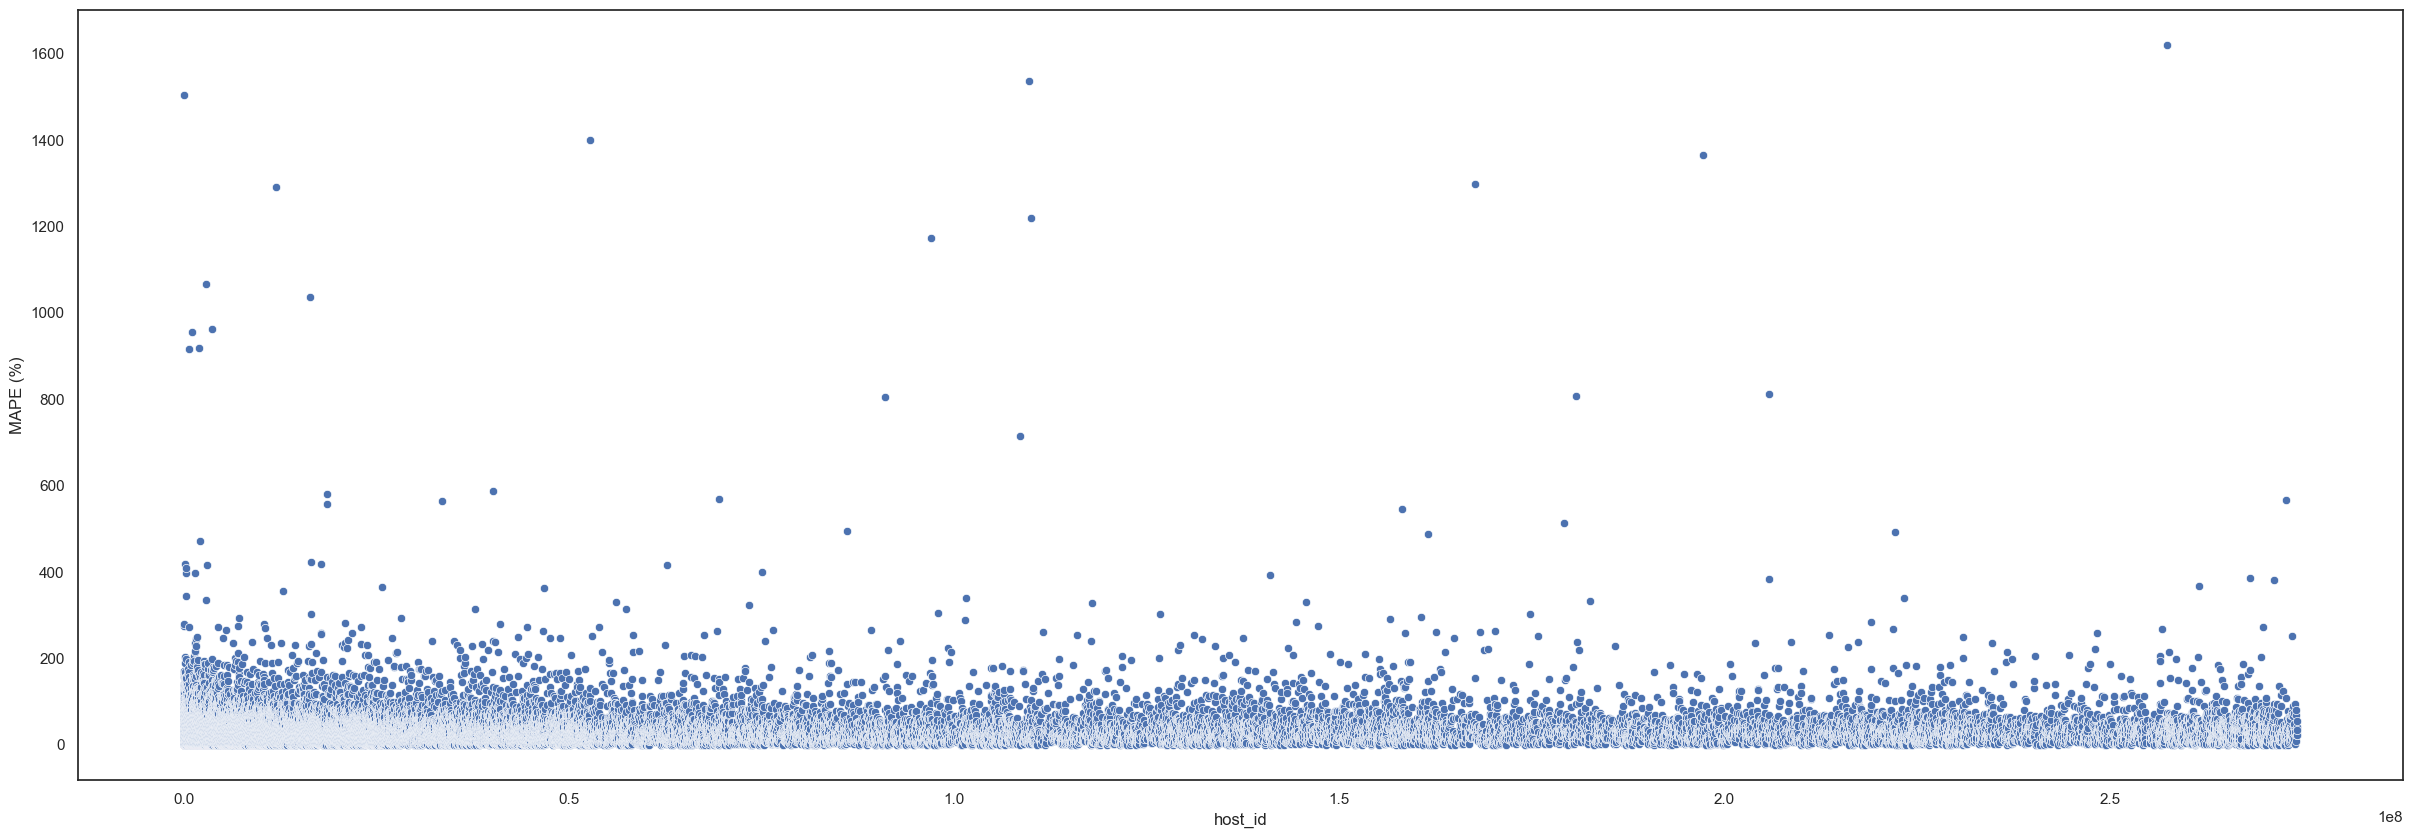

In [129]:
plt.figure(figsize=(30, 10))

sns.scatterplot(x='host_id', y='MAPE (%)', data=sales_report)

In [130]:
profit_from_sales_report = df10_report[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenarios', 0:'Values'})
profit_from_sales_report['Values'] =  profit_from_sales_report['Values'].map('${:,.2f}'.format)
profit_from_sales_report

,Scenarios,Values
0,predictions,"$5,422,212.50"
1,worst_scenario,"$3,465,185.05"
2,best_scenario,"$7,379,239.60"


In [131]:
df10['error'] = df10['price'] - df10['predictions']
df10['error_rate'] = df10['predictions'] / df10['price']

Text(0.5, 1.0, 'Scatter Plot: Predictions vs Error')

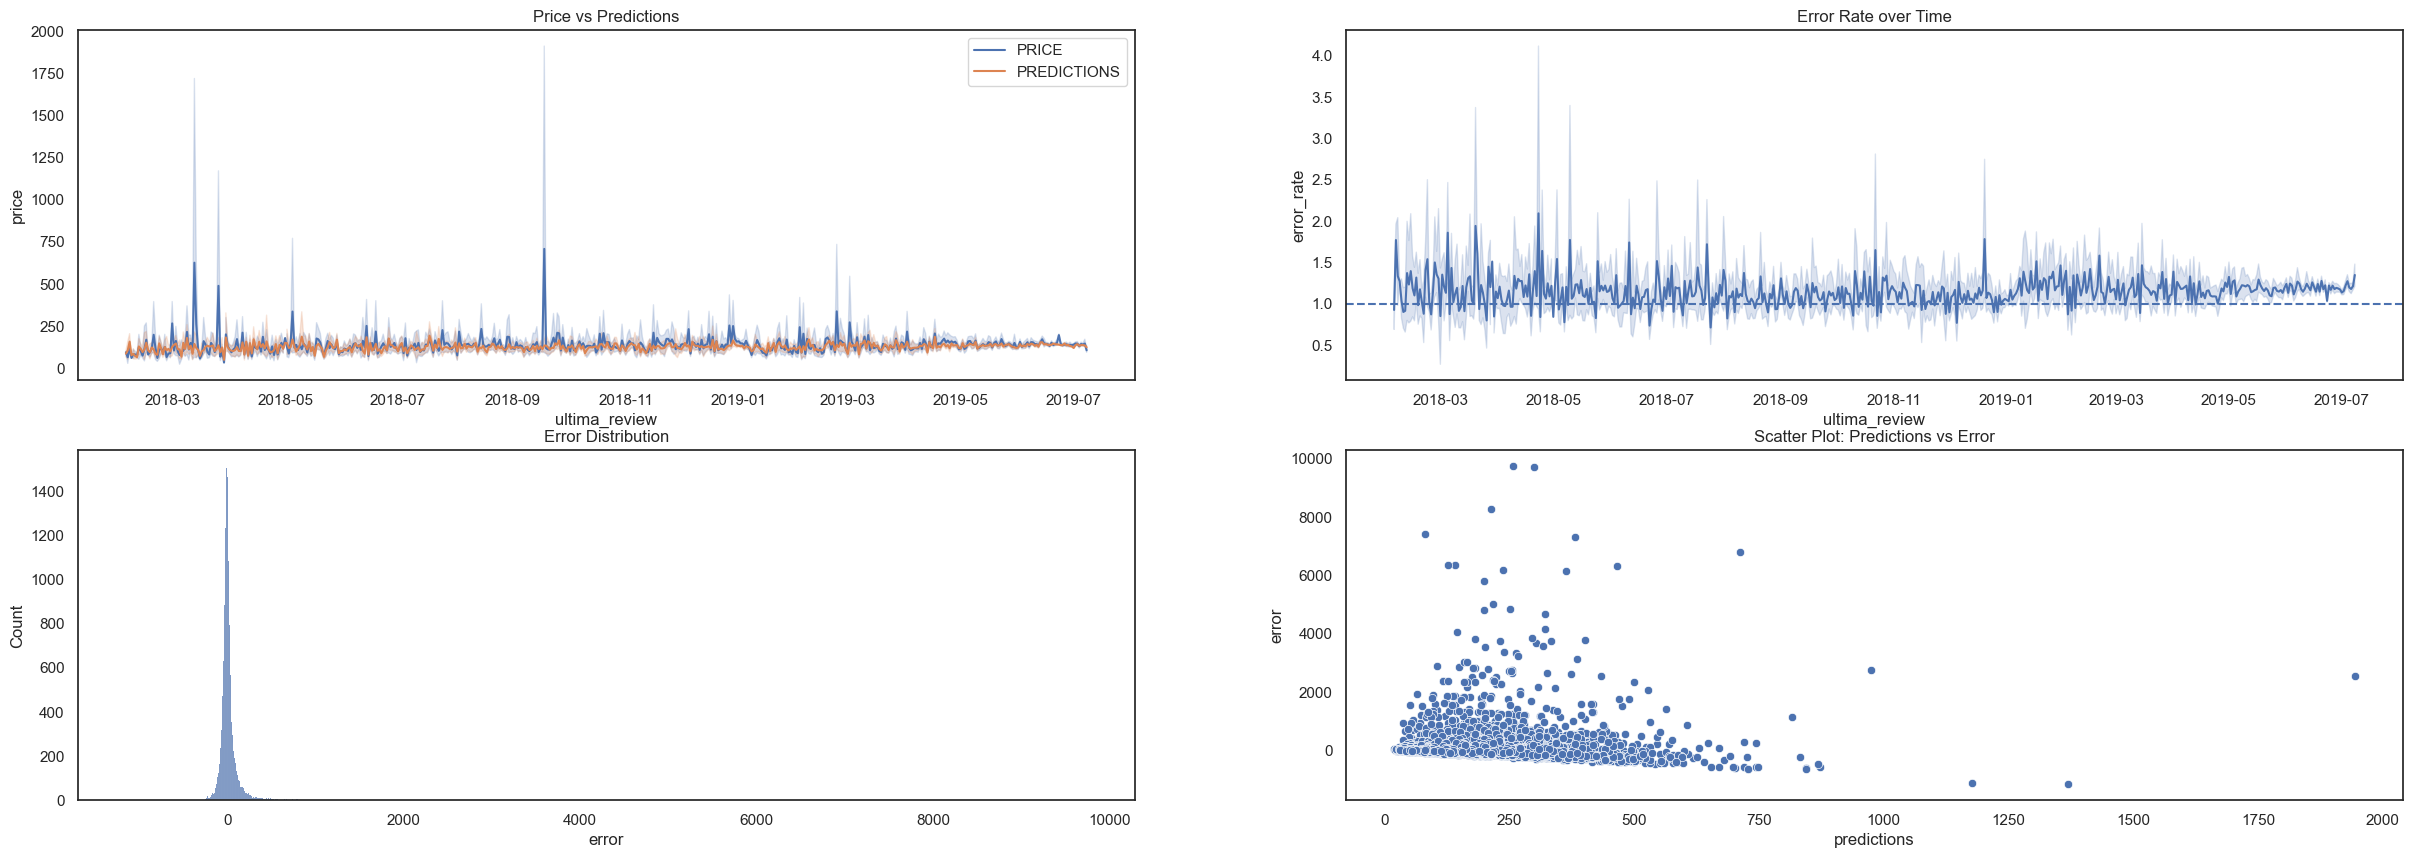

In [132]:
plt.figure(figsize=(30, 10))

plt.subplot(2, 2, 1)
sns.lineplot(x='ultima_review', y='price', data=df10, label='PRICE')
sns.lineplot(x='ultima_review', y='predictions', data=df10, label='PREDICTIONS')
plt.title('Price vs Predictions')
plt.legend()


plt.subplot(2, 2, 2)
sns.lineplot(x='ultima_review', y='error_rate', data=df10)
plt.axhline(1, linestyle='--')
plt.title('Error Rate over Time')

plt.subplot(2, 2, 3)
sns.histplot(x='error', data=df10)
plt.title('Error Distribution')

plt.subplot(2, 2, 4)
sns.scatterplot(x='predictions', y='error', data=df10)
plt.title('Scatter Plot: Predictions vs Error')


## 10.1. Save Actual Database

In [133]:
path = '../data/final/df_final.csv'
df10.to_csv(path, index=False)

In [134]:
df10.head().T

,0,1,2,3,4
room_type_Entire home/apt,1,0,1,1,1
bairro_media,1.709318,-0.305509,0.468691,-0.130479,0.949378
disponibilidade_365,0.972603,1.0,0.531507,0.0,0.353425
host_id,2845,4632,4869,7192,7322
latitude,0.418242,1.176938,-0.519584,1.033005,0.336757
longitude,-0.600342,0.294507,-0.087198,0.24984,-0.412909
nome,37461,43547,14782,18691,24448
host_name,4793,2917,6212,5932,1937
minimo_noites,-0.5,0.0,-0.5,1.75,0.0
calculado_host_listings_count,1.0,0.0,0.0,0.0,0.0
